# Federated Learning + Linear Quantization for RESNET18 & CIFAR10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm
import seaborn as sns
from fedlern.utils import *
from fedlern.train_utils import *
from fedlern.quant_utils import *
from fedlern.models.resnet_v2 import ResNet18

## Relevant Parameters

In [2]:
epoch = 5
rounds = 30#40#25
num_clients = 10
lrn_rate = 0.1
clients_sample_size = int(.3 * num_clients) # Use 30% of available clients
num_workers = 8
train_batch_size = 32 #128
eval_batch_size= 32 #256
quantize_bits = 4
stats = (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)

## Data Loaders
- Divide the test & training data
- Divide the training data among the clients

In [3]:
 # Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)

# split the training data
train_splits = torch.utils.data.random_split(train_dataset, [int(train_dataset.data.shape[0]/num_clients) for i in range(num_clients)])

# Data loaders
train_loaders = [DataLoader(dataset=split, batch_size=train_batch_size, shuffle=True, num_workers=num_workers) for split in train_splits]
test_loader = DataLoader(dataset=test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Files already downloaded and verified



- `server_aggregate` function aggregates the model weights received from every client and updates the global model with the updated weights.

## Global & Clients instatiation
Implement the same elements as before, but:
- We need more instances of the model
- An optimizer for each model

In [4]:
global_model = ResNet18().to(device)
client_models = [ResNet18()
                     .to(device)
                     #.load_state_dict(global_model.state_dict())
                  for _ in range(num_clients)]


# Define the criterion, and pair of optimizers for global model
The first optimizer holds the regular weights, while the second one holds the quantized parameters, which are to be propagated to the clients.

In [5]:
# Optimizer & criterion based on gobal model
global_optimizer = get_model_optimizer(global_model,
                                       learning_rate=lrn_rate,
                                       weight_decay=5e-4)
criterion = nn.CrossEntropyLoss().to(device) # computes the cross-entropy loss between the predicted and true labels

# ----Optimizer for quantized model on global model----
# Copy the parameters
all_G_kernels = [kernel.data.clone().requires_grad_(True)
                for kernel in global_optimizer.param_groups[1]['params']]

kernels = [{'params': all_G_kernels}]

# New optimizer for the quantized weights
goptimizer_quant = optim.SGD(kernels, lr=0)





## Define optimizers for the clients.
Each clients has a pair of optimizers

In [6]:

optimizers = [get_model_optimizer(model,learning_rate=lrn_rate, weight_decay=5e-4) for model in client_models]


optimizers_quant = []
for optimizer in optimizers:
    # Copy the parameters
    all_G_kernels = [kernel.data.clone().requires_grad_(True)
                    for kernel in optimizer.param_groups[1]['params']]

    # Handle of the optimizer parameters
    all_W_kernels = optimizer.param_groups[1]['params']
    kernels = [{'params': all_G_kernels}]

    # New optimizer for the quantized weights
    optimizer_quant = optim.SGD(kernels, lr=0)
    optimizers_quant.append(optimizer_quant)


In [7]:
server_test = to_quantized_model_decorator(global_optimizer, goptimizer_quant)(evaluate_model)

# Decorators magic
# first we wrap the update function with the decorator for the global model switch
server_switch_aggregate = to_quantized_model_decorator(global_optimizer, goptimizer_quant)(server_update)
# then we wrap the update function with the decorator for each of the clients switch
switch_client_weights = [to_quantized_model_decorator(fp32_optimizer, quant_optimizer) for fp32_optimizer, quant_optimizer in zip(optimizers, optimizers_quant)]

In [8]:
server_update_quant  = switch_client_weights[0](server_switch_aggregate)
for funct in switch_client_weights[1:]:
    server_update_quant = funct(server_update_quant)

In [9]:
server_update_quant(global_model, client_models)

In [10]:
# initialize lists to store the training and testing losses and accuracies
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for round in tqdm(range(rounds)):


    # Select n random clients
    selected_clients = np.random.permutation(num_clients)[:clients_sample_size]
    # Train the selected clients
    for client in selected_clients:
        # Individual criterion and optimizer
        print(f"Client {client} training")
        train_loss, train_acc = qtrain_model(model = client_models[client],
                                             train_loader = train_loaders[client],
                                             device = device,
                                             criterion = criterion,
                                             optimizer = optimizers[client],
                                             optimizer_quant = optimizers_quant[client],
                                             num_epochs=epoch,
                                             bits = quantize_bits)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Aggregate in 3 steps
    server_aggregate(global_model, client_models)
    server_quantize(global_optimizer, goptimizer_quant, quantize_bits)
    server_update_quant(global_model, client_models)


    # Test the global model
    test_loss, test_acc = server_test(model=global_model,
                                      test_loader=test_loader,
                                      device=device,
                                      criterion=criterion)

    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"{round}-th ROUND: average train loss {(train_loss / clients_sample_size):0.3g} | test loss {test_loss:0.3g} | test acc: {test_acc:0.3f}")
    
    

  0%|          | 0/10 [00:00<?, ?it/s]

Client 6 training
Epoch: 0/5 Train Loss: 2.803 Train Acc: 0.149
Epoch: 1/5 Train Loss: 2.055 Train Acc: 0.218
Epoch: 2/5 Train Loss: 1.967 Train Acc: 0.256
Epoch: 3/5 Train Loss: 1.917 Train Acc: 0.273
Epoch: 4/5 Train Loss: 1.859 Train Acc: 0.308
Client 5 training
Epoch: 0/5 Train Loss: 3.119 Train Acc: 0.112
Epoch: 1/5 Train Loss: 2.274 Train Acc: 0.143
Epoch: 2/5 Train Loss: 2.113 Train Acc: 0.197
Epoch: 3/5 Train Loss: 2.015 Train Acc: 0.237
Epoch: 4/5 Train Loss: 1.951 Train Acc: 0.262
Client 3 training
Epoch: 0/5 Train Loss: 2.884 Train Acc: 0.146
Epoch: 1/5 Train Loss: 2.084 Train Acc: 0.209
Epoch: 2/5 Train Loss: 2.014 Train Acc: 0.230
Epoch: 3/5 Train Loss: 1.942 Train Acc: 0.265
Epoch: 4/5 Train Loss: 1.892 Train Acc: 0.280


 10%|█         | 1/10 [03:06<27:56, 186.24s/it]

0-th ROUND: average train loss 0.631 | test loss 2.31 | test acc: 0.100
Client 4 training
Epoch: 0/5 Train Loss: 2.174 Train Acc: 0.185
Epoch: 1/5 Train Loss: 2.021 Train Acc: 0.230
Epoch: 2/5 Train Loss: 1.937 Train Acc: 0.260
Epoch: 3/5 Train Loss: 1.872 Train Acc: 0.296
Epoch: 4/5 Train Loss: 1.785 Train Acc: 0.330
Client 8 training
Epoch: 0/5 Train Loss: 2.171 Train Acc: 0.187
Epoch: 1/5 Train Loss: 2.029 Train Acc: 0.220
Epoch: 2/5 Train Loss: 1.966 Train Acc: 0.252
Epoch: 3/5 Train Loss: 1.866 Train Acc: 0.293
Epoch: 4/5 Train Loss: 1.822 Train Acc: 0.315
Client 9 training
Epoch: 0/5 Train Loss: 2.184 Train Acc: 0.191
Epoch: 1/5 Train Loss: 2.018 Train Acc: 0.227
Epoch: 2/5 Train Loss: 1.937 Train Acc: 0.263
Epoch: 3/5 Train Loss: 1.855 Train Acc: 0.301
Epoch: 4/5 Train Loss: 1.774 Train Acc: 0.333


 20%|██        | 2/10 [06:01<23:59, 179.98s/it]

1-th ROUND: average train loss 0.591 | test loss 2.32 | test acc: 0.100
Client 7 training
Epoch: 0/5 Train Loss: 2.026 Train Acc: 0.240
Epoch: 1/5 Train Loss: 1.882 Train Acc: 0.273
Epoch: 2/5 Train Loss: 1.806 Train Acc: 0.322
Epoch: 3/5 Train Loss: 1.728 Train Acc: 0.339
Epoch: 4/5 Train Loss: 1.704 Train Acc: 0.351
Client 9 training
Epoch: 0/5 Train Loss: 2.020 Train Acc: 0.233
Epoch: 1/5 Train Loss: 1.901 Train Acc: 0.276
Epoch: 2/5 Train Loss: 1.822 Train Acc: 0.311
Epoch: 3/5 Train Loss: 1.775 Train Acc: 0.328
Epoch: 4/5 Train Loss: 1.714 Train Acc: 0.360
Client 0 training
Epoch: 0/5 Train Loss: 2.031 Train Acc: 0.232
Epoch: 1/5 Train Loss: 1.900 Train Acc: 0.271
Epoch: 2/5 Train Loss: 1.829 Train Acc: 0.305
Epoch: 3/5 Train Loss: 1.755 Train Acc: 0.332
Epoch: 4/5 Train Loss: 1.723 Train Acc: 0.346


 30%|███       | 3/10 [08:53<20:33, 176.26s/it]

2-th ROUND: average train loss 0.574 | test loss 2.33 | test acc: 0.100
Client 1 training
Epoch: 0/5 Train Loss: 1.954 Train Acc: 0.268
Epoch: 1/5 Train Loss: 1.782 Train Acc: 0.327
Epoch: 2/5 Train Loss: 1.724 Train Acc: 0.364
Epoch: 3/5 Train Loss: 1.654 Train Acc: 0.383
Epoch: 4/5 Train Loss: 1.603 Train Acc: 0.411
Client 3 training
Epoch: 0/5 Train Loss: 1.879 Train Acc: 0.281
Epoch: 1/5 Train Loss: 1.747 Train Acc: 0.337
Epoch: 2/5 Train Loss: 1.702 Train Acc: 0.362
Epoch: 3/5 Train Loss: 1.643 Train Acc: 0.396
Epoch: 4/5 Train Loss: 1.574 Train Acc: 0.413
Client 6 training
Epoch: 0/5 Train Loss: 1.887 Train Acc: 0.279
Epoch: 1/5 Train Loss: 1.769 Train Acc: 0.327
Epoch: 2/5 Train Loss: 1.675 Train Acc: 0.375
Epoch: 3/5 Train Loss: 1.652 Train Acc: 0.374
Epoch: 4/5 Train Loss: 1.589 Train Acc: 0.398


 40%|████      | 4/10 [11:48<17:35, 175.88s/it]

3-th ROUND: average train loss 0.53 | test loss 2.34 | test acc: 0.100
Client 7 training
Epoch: 0/5 Train Loss: 1.802 Train Acc: 0.320
Epoch: 1/5 Train Loss: 1.685 Train Acc: 0.365
Epoch: 2/5 Train Loss: 1.608 Train Acc: 0.406
Epoch: 3/5 Train Loss: 1.538 Train Acc: 0.432
Epoch: 4/5 Train Loss: 1.507 Train Acc: 0.445
Client 4 training
Epoch: 0/5 Train Loss: 1.778 Train Acc: 0.328
Epoch: 1/5 Train Loss: 1.670 Train Acc: 0.377
Epoch: 2/5 Train Loss: 1.589 Train Acc: 0.414
Epoch: 3/5 Train Loss: 1.514 Train Acc: 0.440
Epoch: 4/5 Train Loss: 1.451 Train Acc: 0.468
Client 1 training
Epoch: 0/5 Train Loss: 1.836 Train Acc: 0.320
Epoch: 1/5 Train Loss: 1.722 Train Acc: 0.358
Epoch: 2/5 Train Loss: 1.656 Train Acc: 0.386
Epoch: 3/5 Train Loss: 1.576 Train Acc: 0.419
Epoch: 4/5 Train Loss: 1.532 Train Acc: 0.443


 50%|█████     | 5/10 [14:53<14:55, 179.11s/it]

4-th ROUND: average train loss 0.511 | test loss 2.34 | test acc: 0.105
Client 3 training
Epoch: 0/5 Train Loss: 1.679 Train Acc: 0.380
Epoch: 1/5 Train Loss: 1.567 Train Acc: 0.421
Epoch: 2/5 Train Loss: 1.455 Train Acc: 0.472
Epoch: 3/5 Train Loss: 1.410 Train Acc: 0.484
Epoch: 4/5 Train Loss: 1.367 Train Acc: 0.507
Client 0 training
Epoch: 0/5 Train Loss: 1.693 Train Acc: 0.368
Epoch: 1/5 Train Loss: 1.592 Train Acc: 0.401
Epoch: 2/5 Train Loss: 1.497 Train Acc: 0.441
Epoch: 3/5 Train Loss: 1.442 Train Acc: 0.471
Epoch: 4/5 Train Loss: 1.387 Train Acc: 0.502
Client 1 training
Epoch: 0/5 Train Loss: 1.677 Train Acc: 0.380
Epoch: 1/5 Train Loss: 1.620 Train Acc: 0.402
Epoch: 2/5 Train Loss: 1.512 Train Acc: 0.448
Epoch: 3/5 Train Loss: 1.460 Train Acc: 0.465
Epoch: 4/5 Train Loss: 1.409 Train Acc: 0.486


 60%|██████    | 6/10 [17:49<11:52, 178.05s/it]

5-th ROUND: average train loss 0.47 | test loss 2.29 | test acc: 0.104
Client 2 training
Epoch: 0/5 Train Loss: 1.582 Train Acc: 0.419
Epoch: 1/5 Train Loss: 1.467 Train Acc: 0.457
Epoch: 2/5 Train Loss: 1.429 Train Acc: 0.475
Epoch: 3/5 Train Loss: 1.326 Train Acc: 0.523
Epoch: 4/5 Train Loss: 1.279 Train Acc: 0.531
Client 0 training
Epoch: 0/5 Train Loss: 1.567 Train Acc: 0.417
Epoch: 1/5 Train Loss: 1.450 Train Acc: 0.465
Epoch: 2/5 Train Loss: 1.354 Train Acc: 0.502
Epoch: 3/5 Train Loss: 1.291 Train Acc: 0.529
Epoch: 4/5 Train Loss: 1.244 Train Acc: 0.562
Client 3 training
Epoch: 0/5 Train Loss: 1.541 Train Acc: 0.429
Epoch: 1/5 Train Loss: 1.419 Train Acc: 0.481
Epoch: 2/5 Train Loss: 1.330 Train Acc: 0.521
Epoch: 3/5 Train Loss: 1.291 Train Acc: 0.530
Epoch: 4/5 Train Loss: 1.229 Train Acc: 0.559


 70%|███████   | 7/10 [21:23<09:28, 189.66s/it]

6-th ROUND: average train loss 0.41 | test loss 2.23 | test acc: 0.166
Client 2 training
Epoch: 0/5 Train Loss: 1.457 Train Acc: 0.468
Epoch: 1/5 Train Loss: 1.350 Train Acc: 0.512
Epoch: 2/5 Train Loss: 1.274 Train Acc: 0.536
Epoch: 3/5 Train Loss: 1.226 Train Acc: 0.562
Epoch: 4/5 Train Loss: 1.176 Train Acc: 0.568
Client 9 training
Epoch: 0/5 Train Loss: 1.452 Train Acc: 0.471
Epoch: 1/5 Train Loss: 1.356 Train Acc: 0.504
Epoch: 2/5 Train Loss: 1.281 Train Acc: 0.537
Epoch: 3/5 Train Loss: 1.244 Train Acc: 0.549
Epoch: 4/5 Train Loss: 1.194 Train Acc: 0.582
Client 4 training
Epoch: 0/5 Train Loss: 1.414 Train Acc: 0.487
Epoch: 1/5 Train Loss: 1.327 Train Acc: 0.512
Epoch: 2/5 Train Loss: 1.247 Train Acc: 0.548
Epoch: 3/5 Train Loss: 1.189 Train Acc: 0.575
Epoch: 4/5 Train Loss: 1.136 Train Acc: 0.591


 80%|████████  | 8/10 [25:05<06:39, 199.88s/it]

7-th ROUND: average train loss 0.379 | test loss 2.17 | test acc: 0.207
Client 0 training
Epoch: 0/5 Train Loss: 1.331 Train Acc: 0.520
Epoch: 1/5 Train Loss: 1.240 Train Acc: 0.549
Epoch: 2/5 Train Loss: 1.159 Train Acc: 0.590
Epoch: 3/5 Train Loss: 1.139 Train Acc: 0.600
Epoch: 4/5 Train Loss: 1.098 Train Acc: 0.612
Client 1 training
Epoch: 0/5 Train Loss: 1.352 Train Acc: 0.513
Epoch: 1/5 Train Loss: 1.255 Train Acc: 0.552
Epoch: 2/5 Train Loss: 1.200 Train Acc: 0.569
Epoch: 3/5 Train Loss: 1.157 Train Acc: 0.589
Epoch: 4/5 Train Loss: 1.126 Train Acc: 0.605
Client 9 training
Epoch: 0/5 Train Loss: 1.343 Train Acc: 0.508
Epoch: 1/5 Train Loss: 1.276 Train Acc: 0.534
Epoch: 2/5 Train Loss: 1.219 Train Acc: 0.560
Epoch: 3/5 Train Loss: 1.156 Train Acc: 0.596
Epoch: 4/5 Train Loss: 1.113 Train Acc: 0.607


 90%|█████████ | 9/10 [28:46<03:26, 206.46s/it]

8-th ROUND: average train loss 0.371 | test loss 2.13 | test acc: 0.250
Client 5 training
Epoch: 0/5 Train Loss: 1.253 Train Acc: 0.558
Epoch: 1/5 Train Loss: 1.192 Train Acc: 0.574
Epoch: 2/5 Train Loss: 1.122 Train Acc: 0.606
Epoch: 3/5 Train Loss: 1.089 Train Acc: 0.616
Epoch: 4/5 Train Loss: 1.041 Train Acc: 0.636
Client 9 training
Epoch: 0/5 Train Loss: 1.240 Train Acc: 0.558
Epoch: 1/5 Train Loss: 1.187 Train Acc: 0.579
Epoch: 2/5 Train Loss: 1.119 Train Acc: 0.600
Epoch: 3/5 Train Loss: 1.088 Train Acc: 0.617
Epoch: 4/5 Train Loss: 1.056 Train Acc: 0.620
Client 1 training
Epoch: 0/5 Train Loss: 1.221 Train Acc: 0.561
Epoch: 1/5 Train Loss: 1.195 Train Acc: 0.574
Epoch: 2/5 Train Loss: 1.121 Train Acc: 0.598
Epoch: 3/5 Train Loss: 1.084 Train Acc: 0.621
Epoch: 4/5 Train Loss: 1.041 Train Acc: 0.630


100%|██████████| 10/10 [32:11<00:00, 193.16s/it]

9-th ROUND: average train loss 0.347 | test loss 2.04 | test acc: 0.290


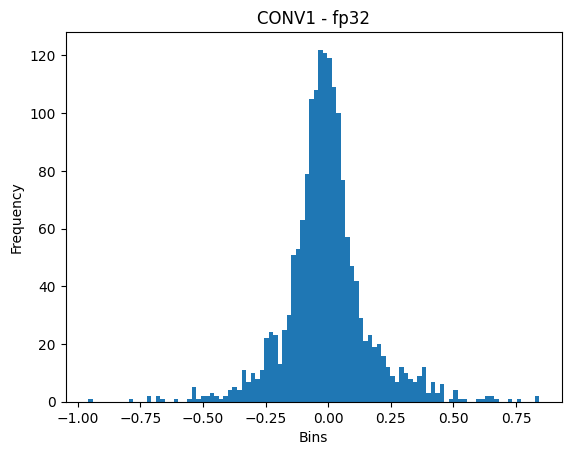

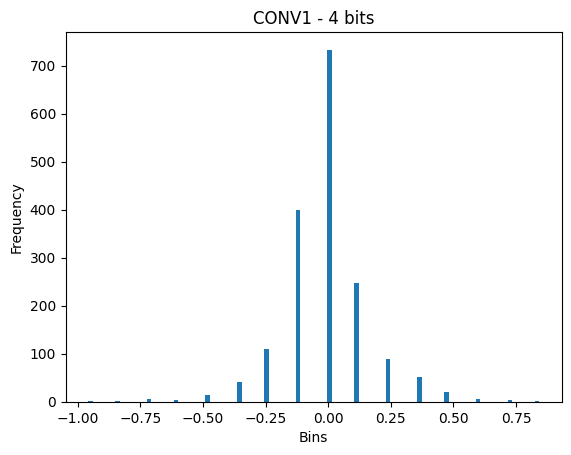

In [11]:
quantized_histogram = to_quantized_model_decorator(global_optimizer, goptimizer_quant)(histogram_conv1)

# Evaluate the model's histogram
before = histogram_conv1(global_model)
plot_histogram(before[0], before[1],f"CONV1 - fp32")


after = quantized_histogram(global_model)
plot_histogram(after[0], after[1], f"CONV1 - {quantize_bits} bits")


In [12]:
print(before[0].shape, "\n",after[0].shape)

torch.Size([100]) 
 torch.Size([100])


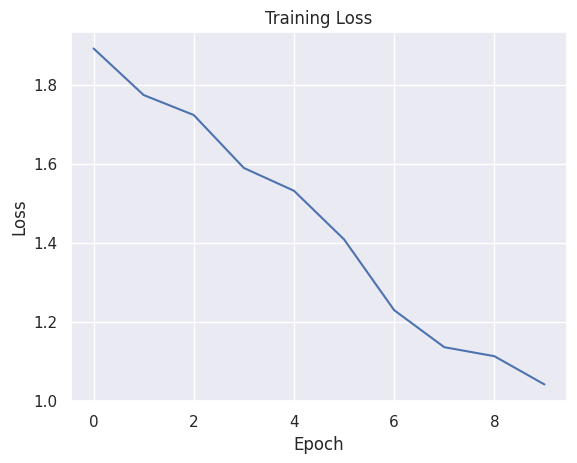

In [13]:
# plot the training loss
sns.set(style='darkgrid')
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [14]:
train_accs = [d.item() for d in train_accs]
test_accs = [d.item() for d in test_accs]

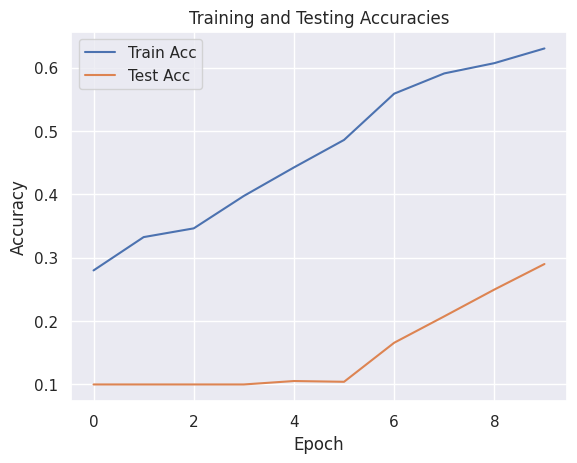

In [15]:
# plot the training and testing accuracies
sns.set(style='darkgrid')
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [16]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")
# Test the model
loss, acc = server_test(global_model, test_loader, device,criterion=criterion)
print(f'Loss: {loss}, Accuracy: {acc*100}%')
print_model_size(global_model)

# Measure inference latency
cpu_inference_latency = measure_inference_latency(model=global_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
gpu_inference_latency = measure_inference_latency(model=global_model, device=cuda_device, input_size=(1,3,32,32), num_samples=100)
print("CPU Inference Latency: {:.2f} ms / sample".format(cpu_inference_latency * 1000))
print("CUDA Inference Latency: {:.2f} ms / sample".format(gpu_inference_latency * 1000))

Loss: 2.043921530342102, Accuracy: 29.009998321533203%
44.77 MB
CPU Inference Latency: 6.58 ms / sample
CUDA Inference Latency: 2.94 ms / sample


In [17]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")
# Test the model
loss, acc = evaluate_model(global_model, test_loader, device,criterion=criterion)
print(f'Loss: {loss}, Accuracy: {acc*100}%')
print_model_size(global_model)

# Measure inference latency
cpu_inference_latency = measure_inference_latency(model=global_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
gpu_inference_latency = measure_inference_latency(model=global_model, device=cuda_device, input_size=(1,3,32,32), num_samples=100)
print("CPU Inference Latency: {:.2f} ms / sample".format(cpu_inference_latency * 1000))
print("CUDA Inference Latency: {:.2f} ms / sample".format(gpu_inference_latency * 1000))

Loss: 2.0280835109710695, Accuracy: 29.35999870300293%
44.77 MB
CPU Inference Latency: 10.60 ms / sample
CUDA Inference Latency: 2.94 ms / sample


In [18]:
save_model(global_model, "saved_models", f'resnet_fedlern_global_{time_stamp()}.pth')


In [19]:
save_quantized_model = to_quantized_model_decorator(global_optimizer, goptimizer_quant)(save_model)
save_quantized_model(global_model, "saved_models", f'resnet_fedlern_{quantize_bits}bits_{time_stamp()}.pth')

In [20]:
def get_model_dict(model):
    return model.state_dict().copy()

dicta = get_model_dict(global_model)
dictd = to_quantized_model_decorator(global_optimizer, goptimizer_quant)(get_model_dict)(global_model)

conv1.weight


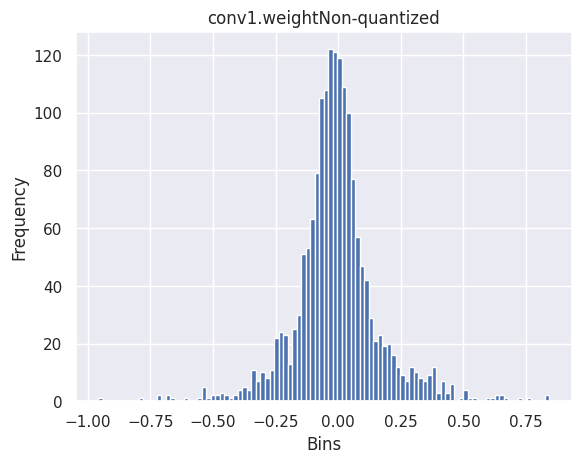

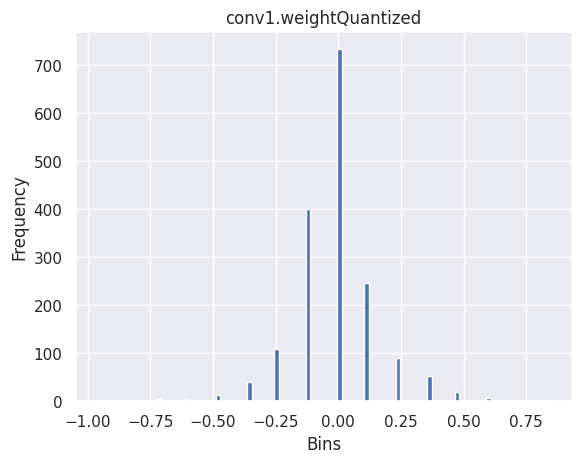

torch.Size([100])
torch.Size([101])
bn1.weight


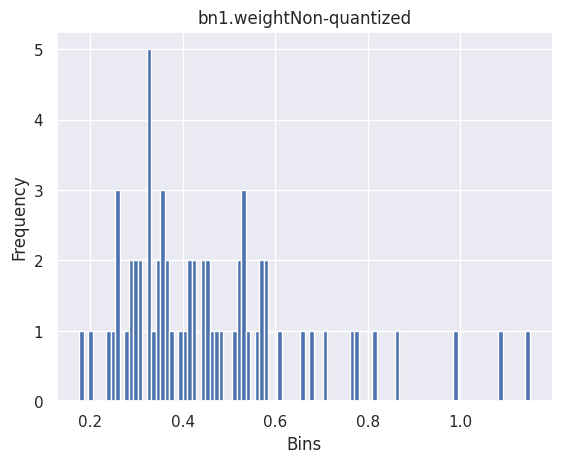

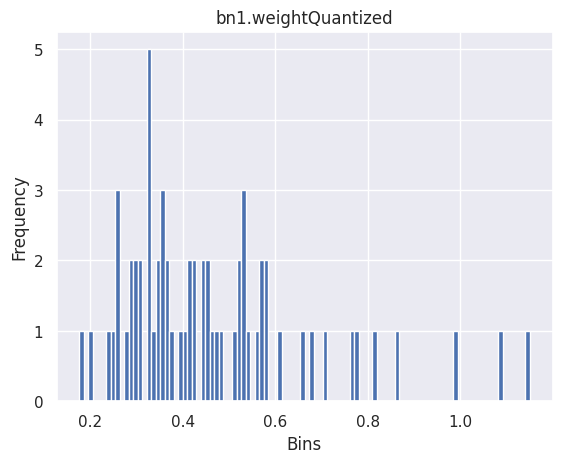

bn1.bias


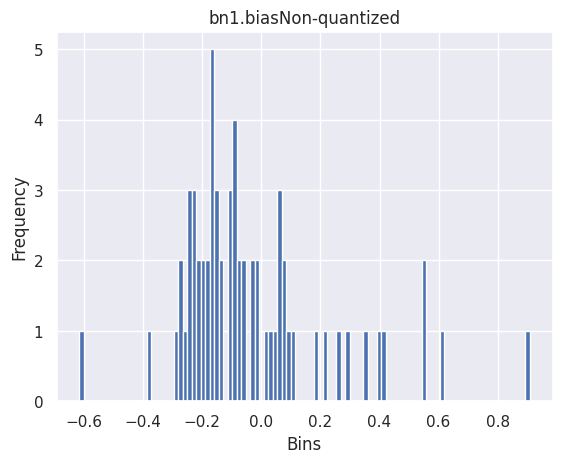

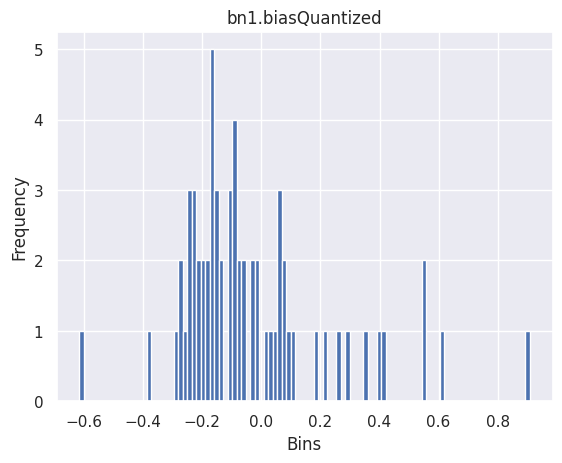

layer1.0.conv1.weight


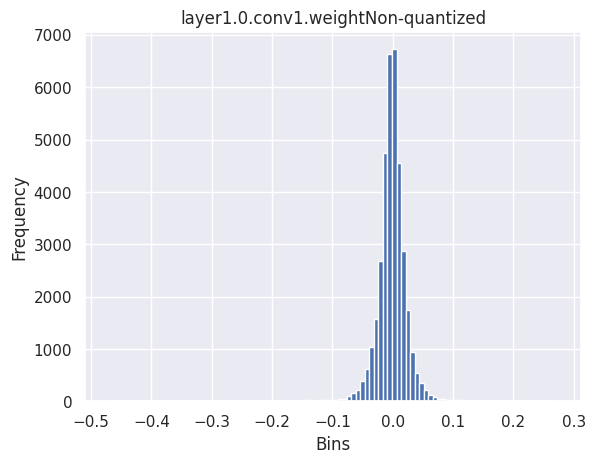

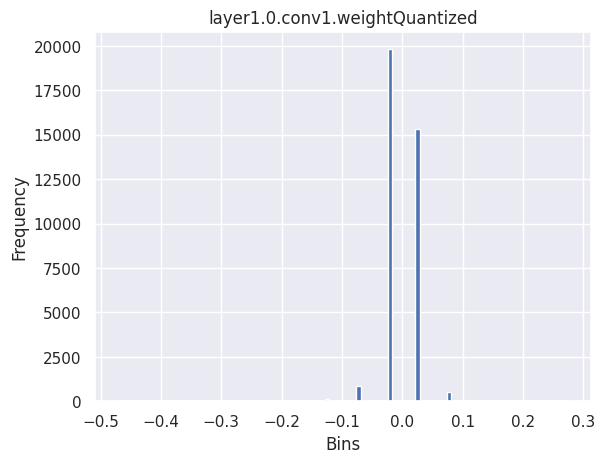

torch.Size([100])
torch.Size([101])
layer1.0.bn1.weight


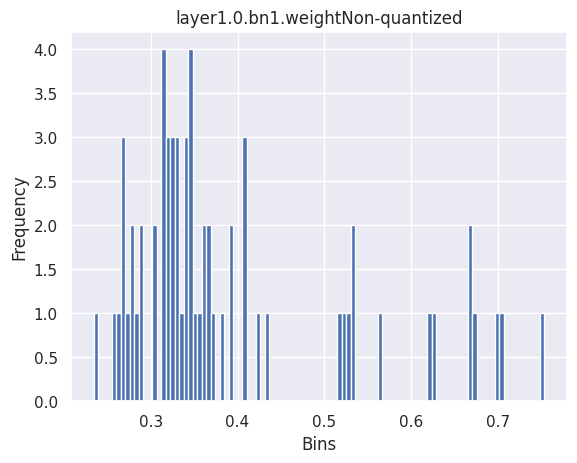

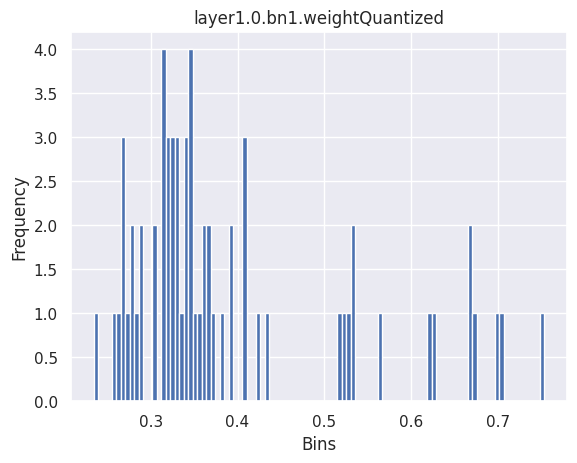

layer1.0.bn1.bias


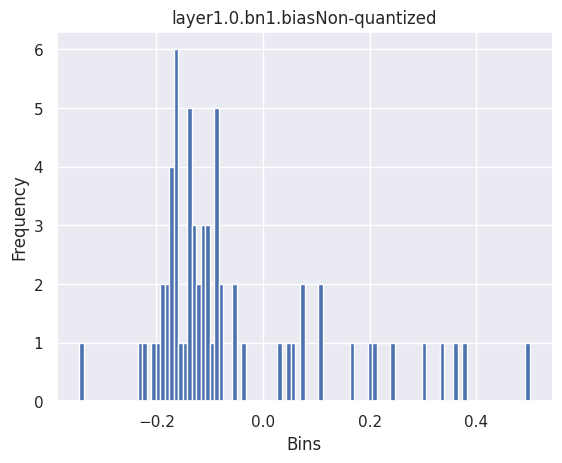

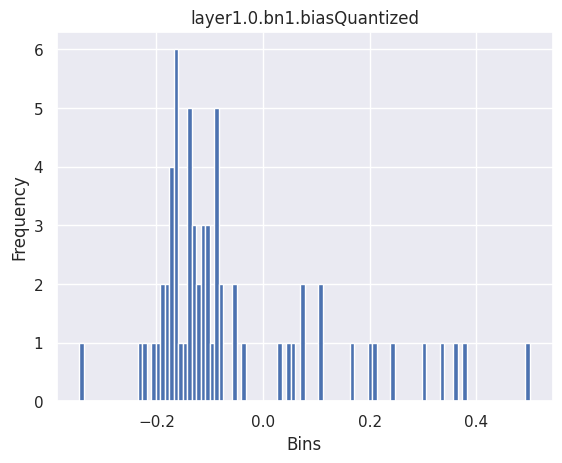

layer1.0.conv2.weight


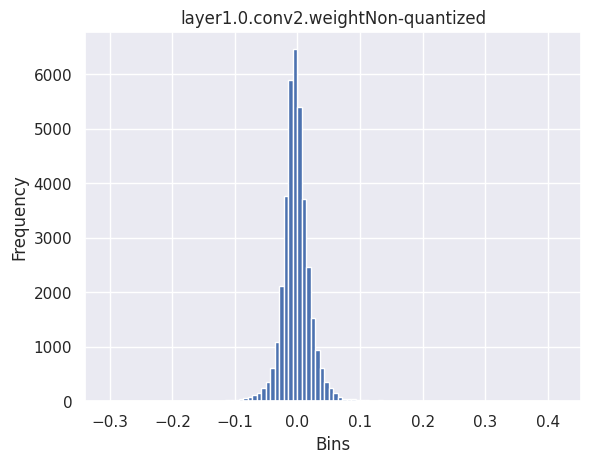

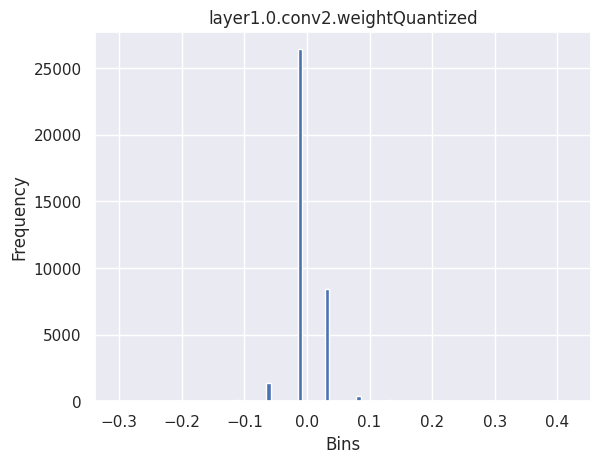

torch.Size([100])
torch.Size([101])
layer1.0.bn2.weight


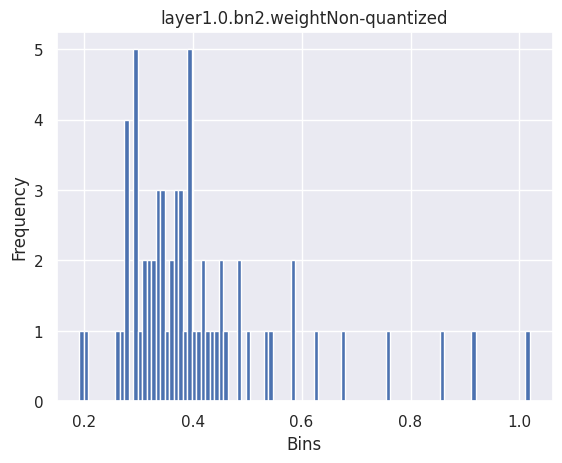

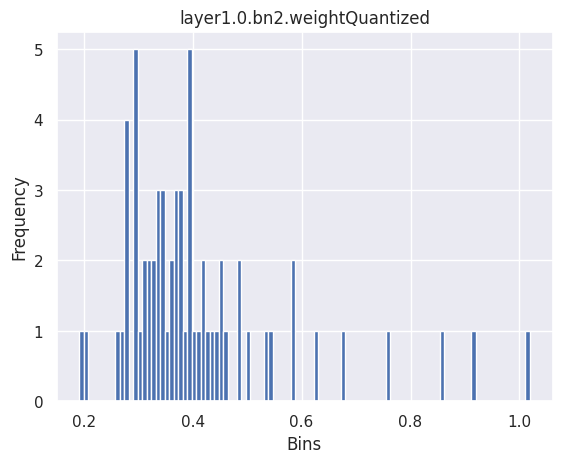

layer1.0.bn2.bias


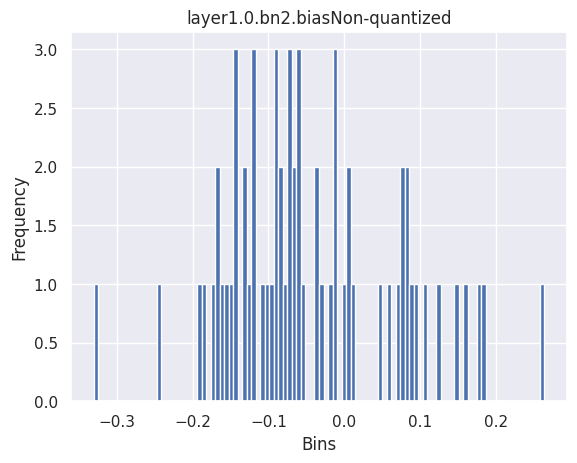

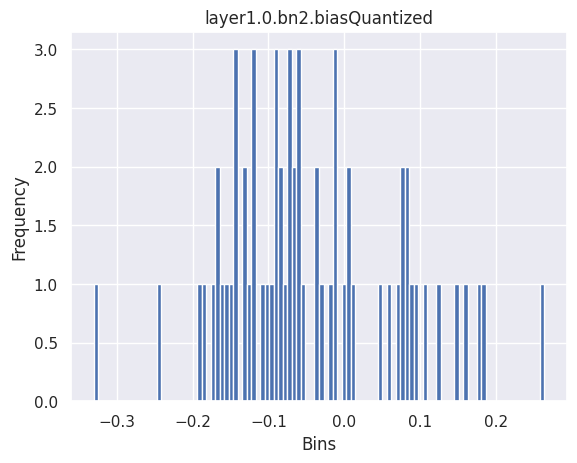

layer1.1.conv1.weight


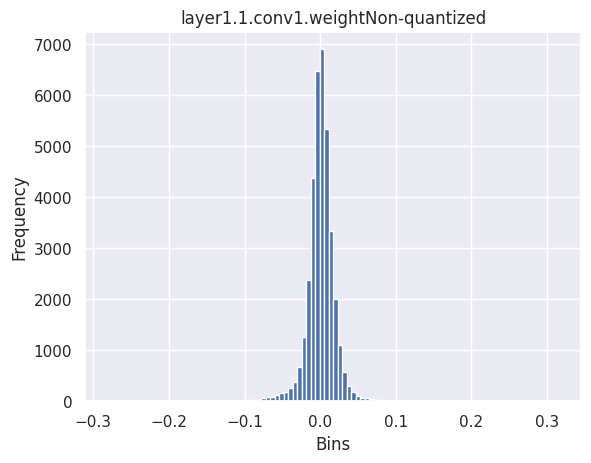

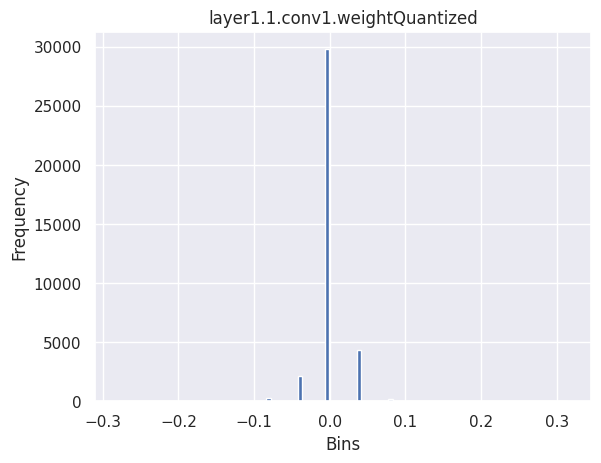

torch.Size([100])
torch.Size([101])
layer1.1.bn1.weight


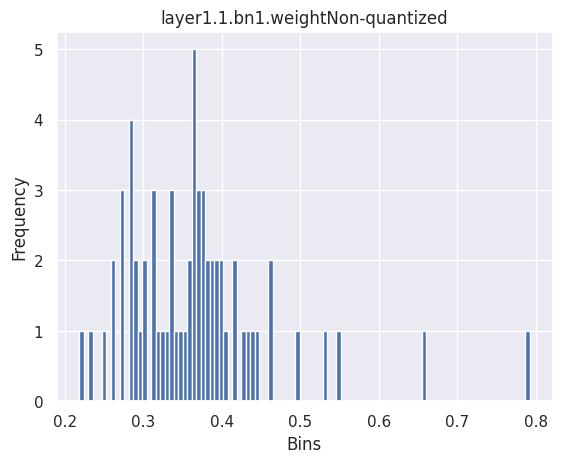

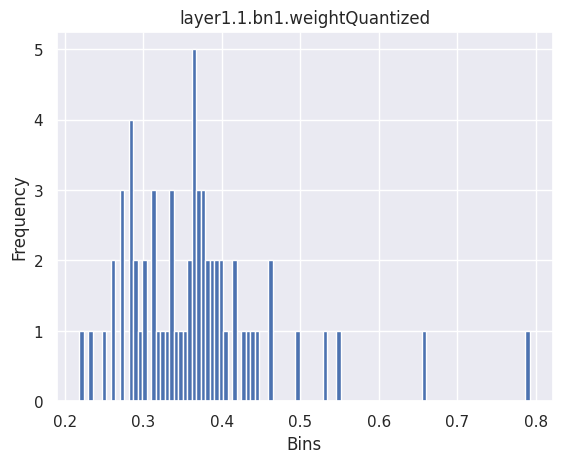

layer1.1.bn1.bias


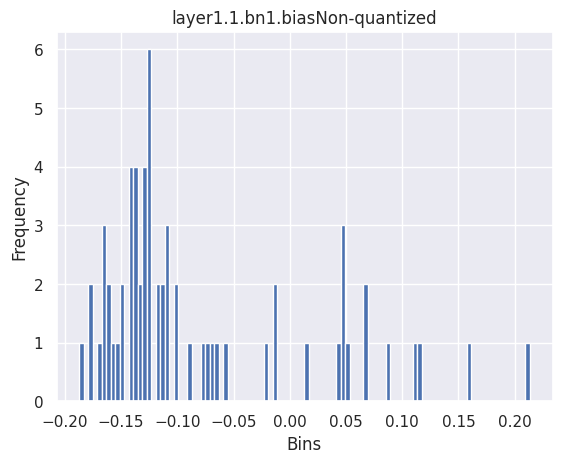

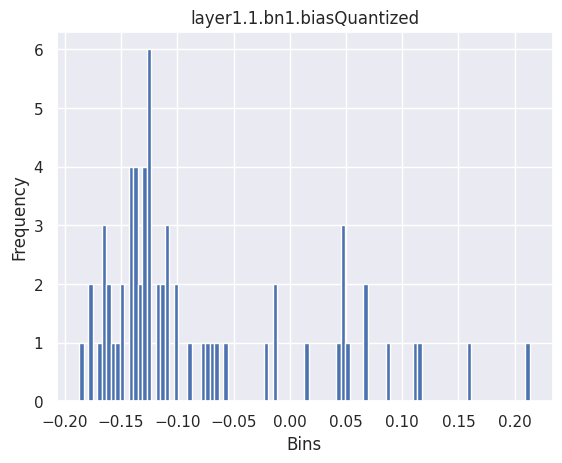

layer1.1.conv2.weight


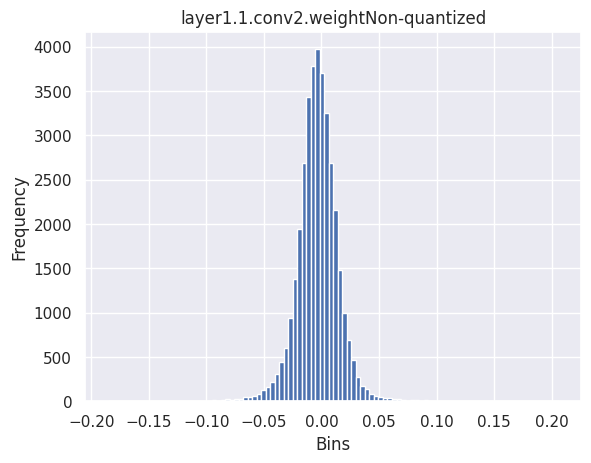

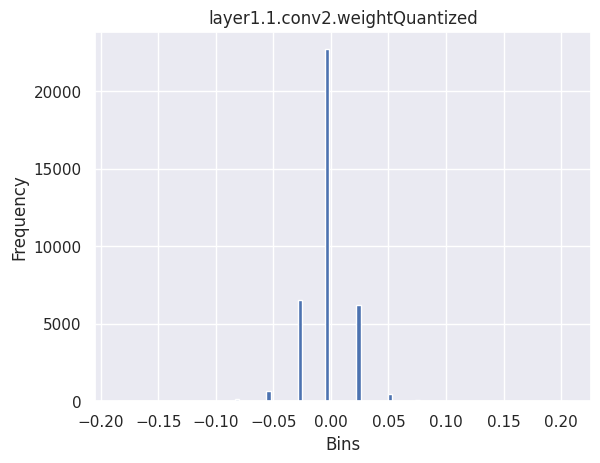

torch.Size([100])
torch.Size([101])
layer1.1.bn2.weight


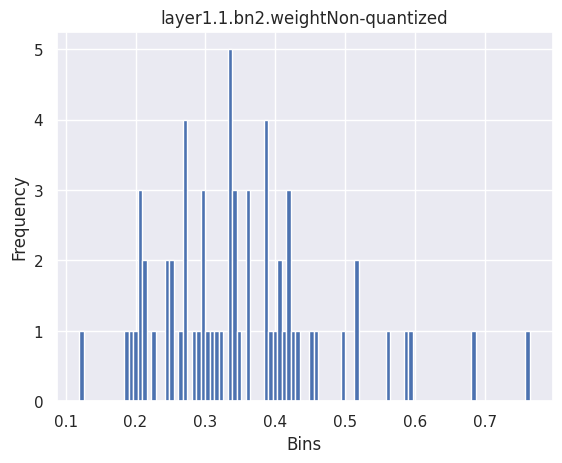

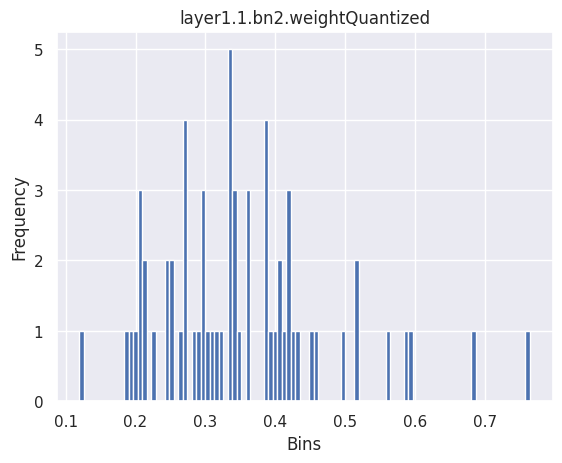

layer1.1.bn2.bias


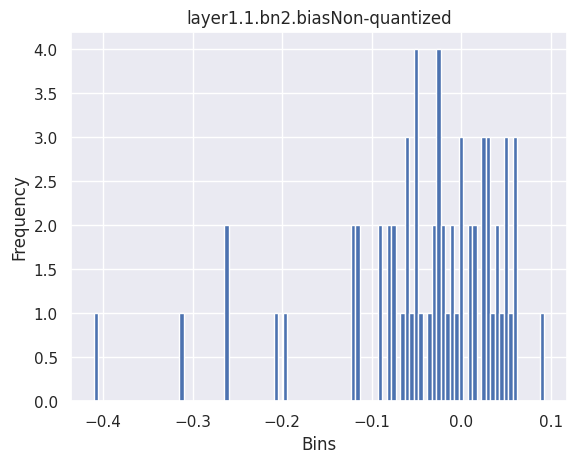

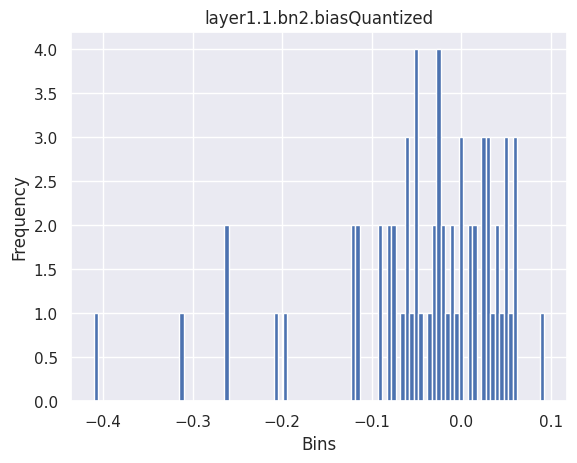

layer2.0.conv1.weight


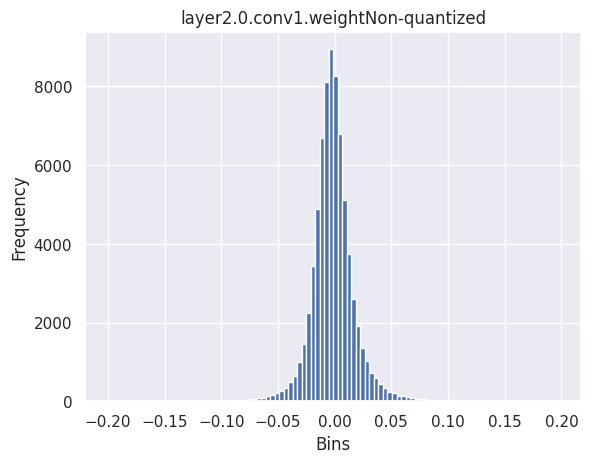

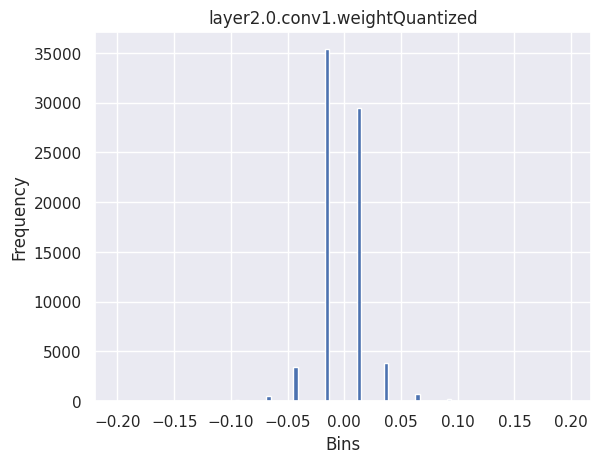

torch.Size([100])
torch.Size([101])
layer2.0.bn1.weight


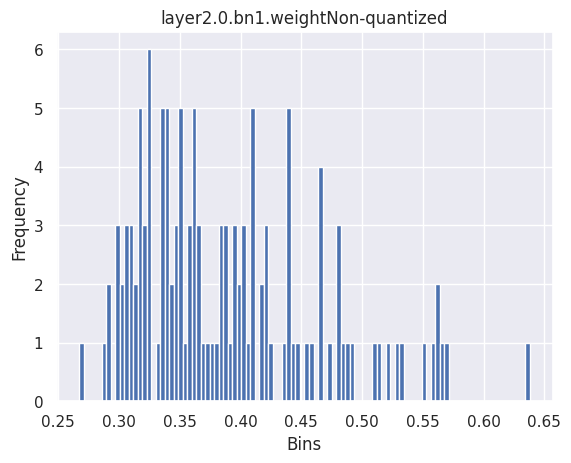

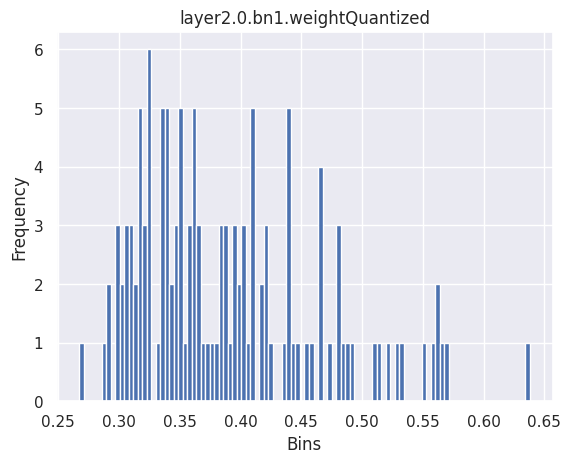

layer2.0.bn1.bias


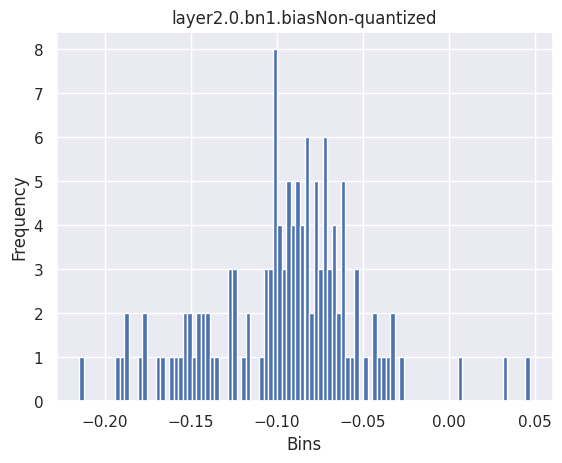

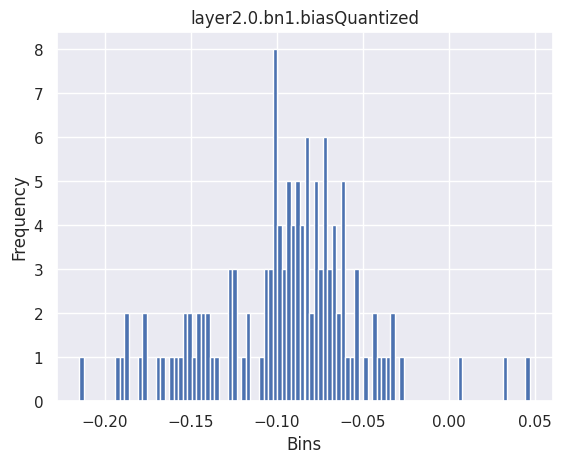

layer2.0.conv2.weight


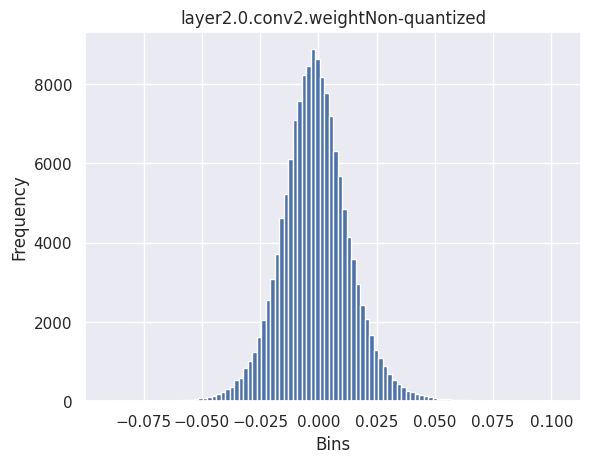

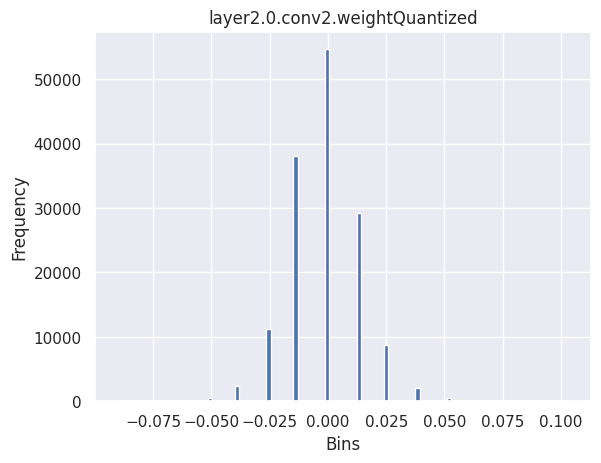

torch.Size([100])
torch.Size([101])
layer2.0.bn2.weight


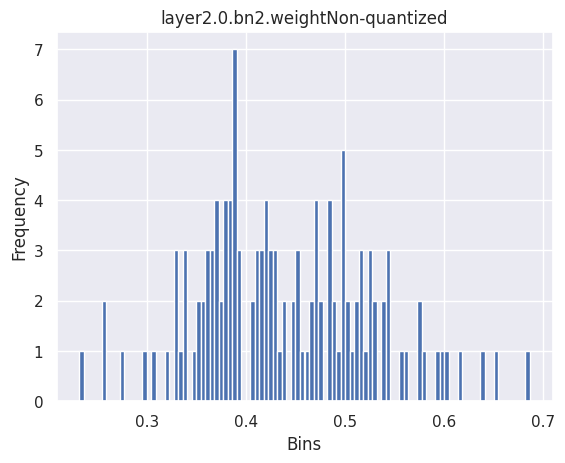

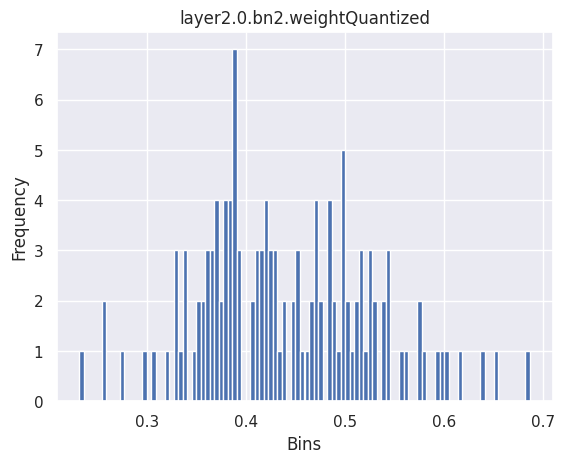

layer2.0.bn2.bias


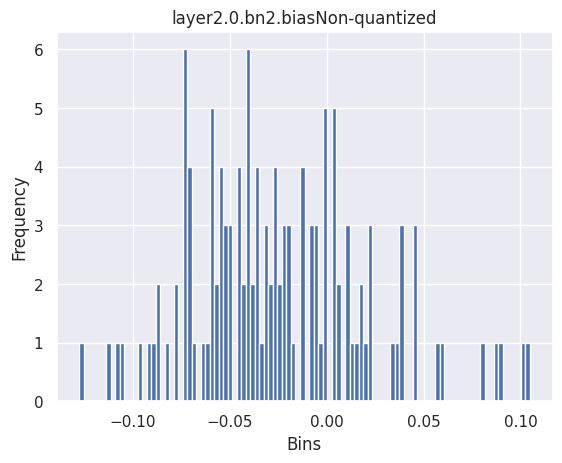

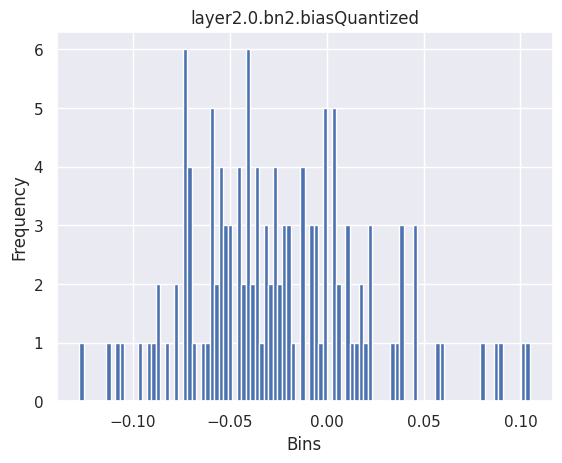

layer2.0.shortcut.0.weight


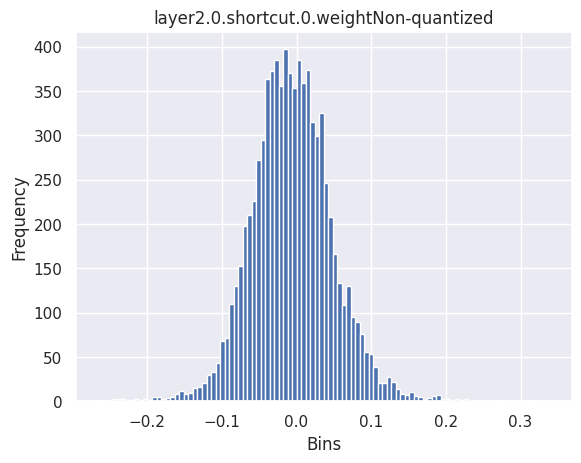

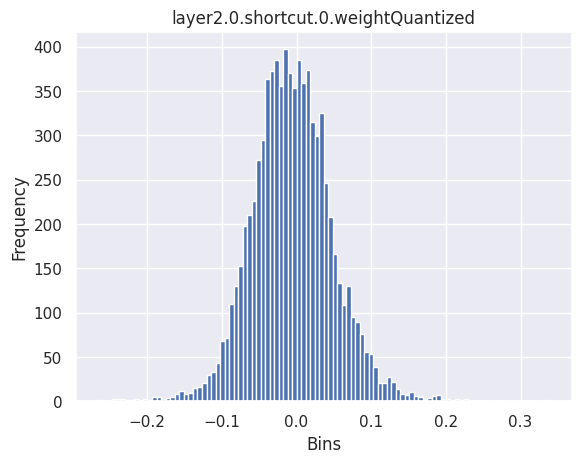

layer2.0.shortcut.1.weight


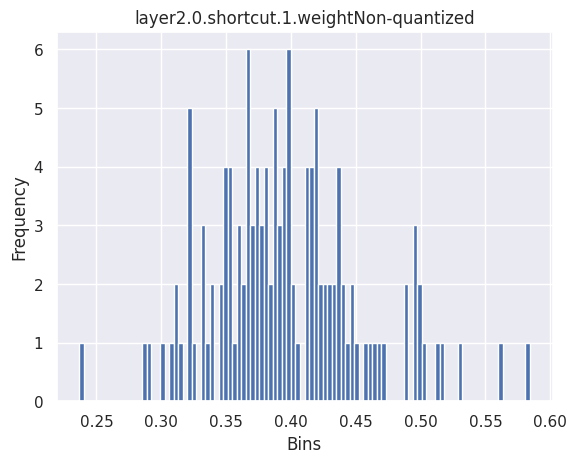

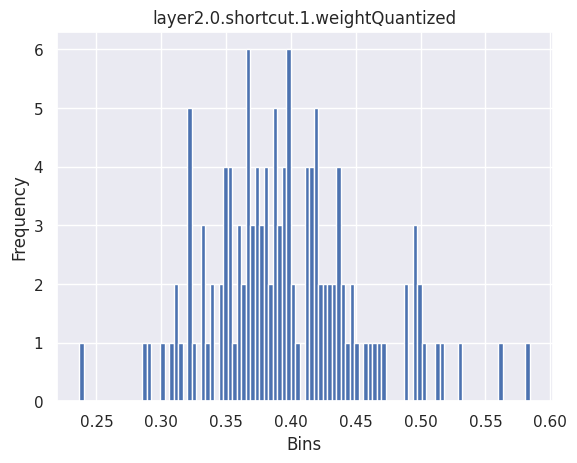

layer2.0.shortcut.1.bias


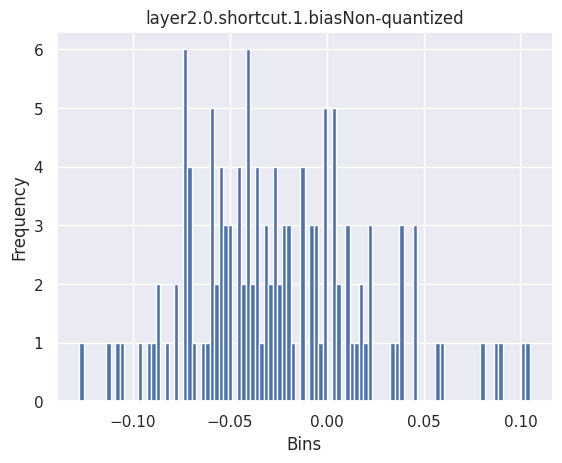

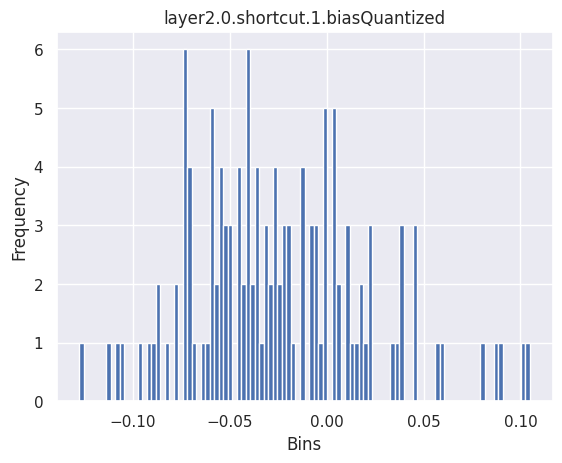

layer2.1.conv1.weight


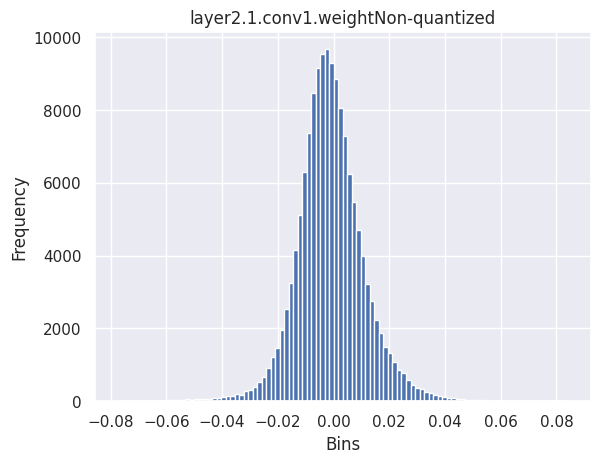

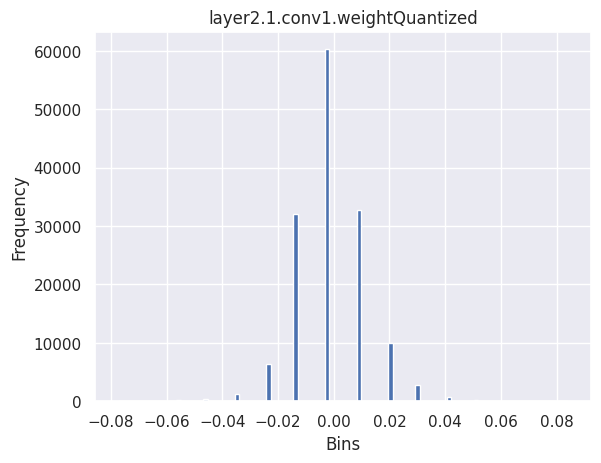

torch.Size([100])
torch.Size([101])
layer2.1.bn1.weight


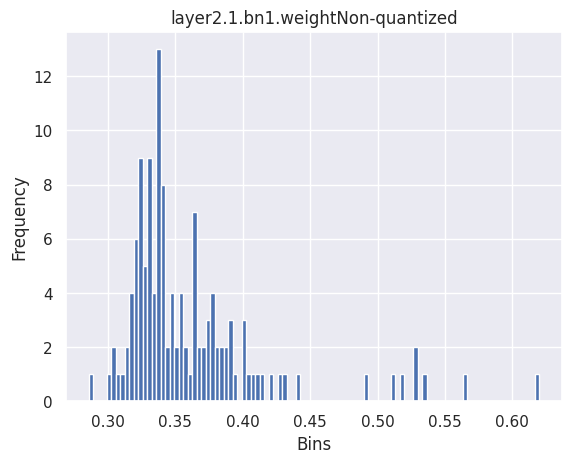

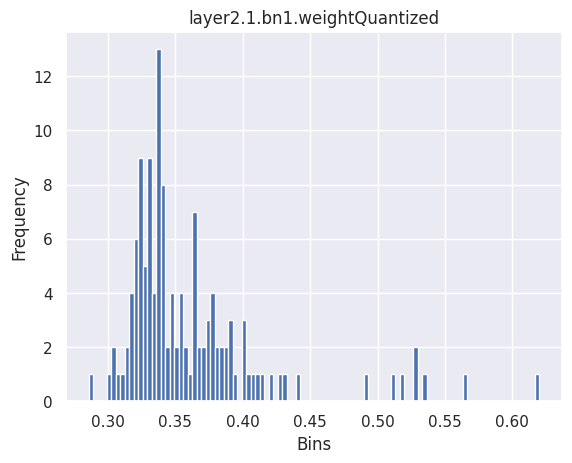

layer2.1.bn1.bias


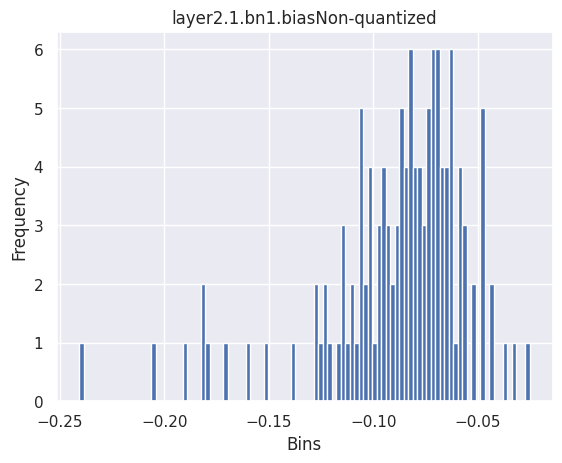

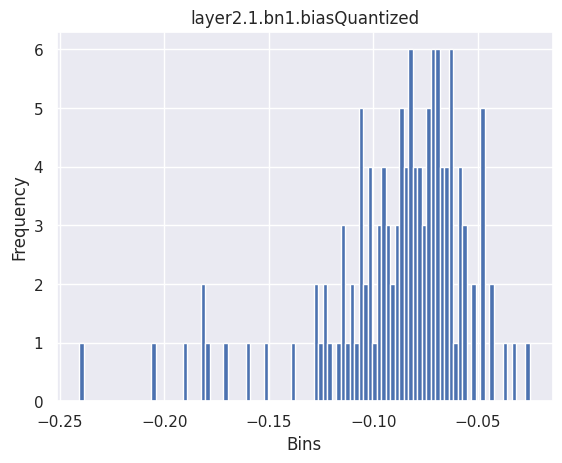

layer2.1.conv2.weight


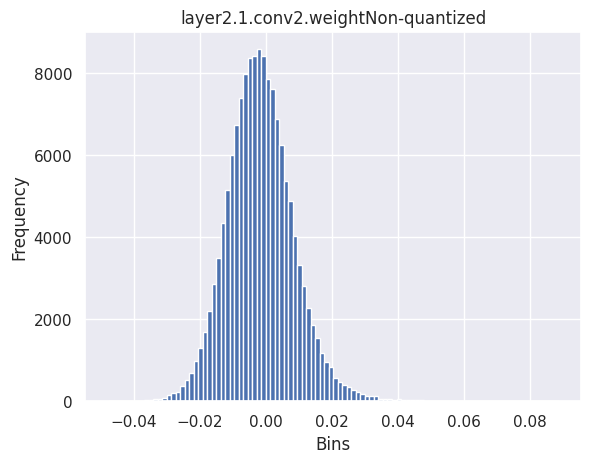

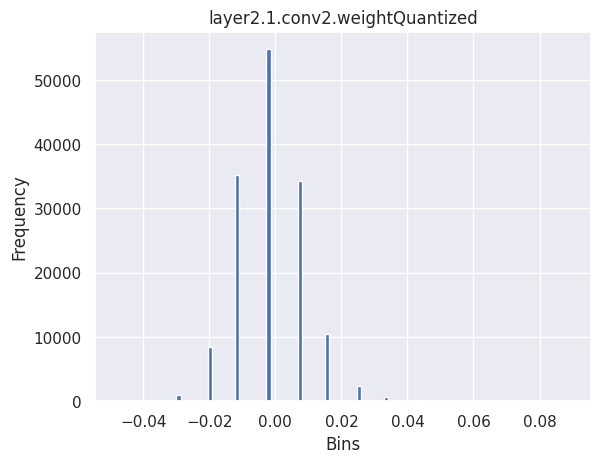

torch.Size([100])
torch.Size([101])
layer2.1.bn2.weight


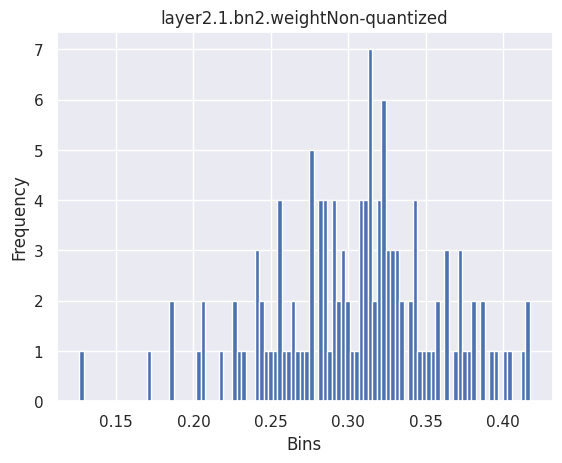

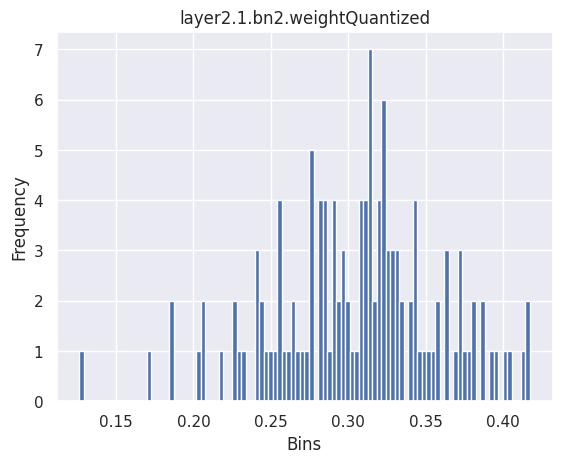

layer2.1.bn2.bias


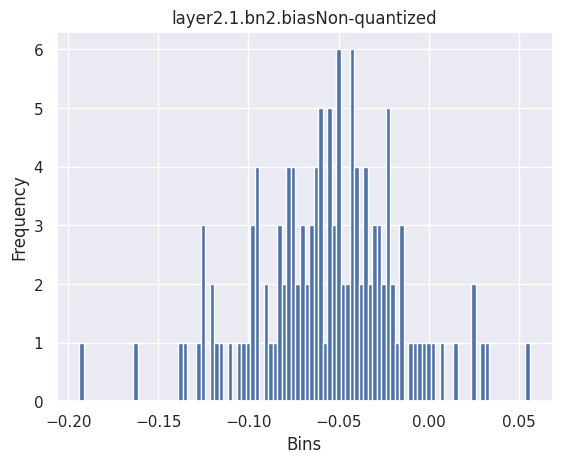

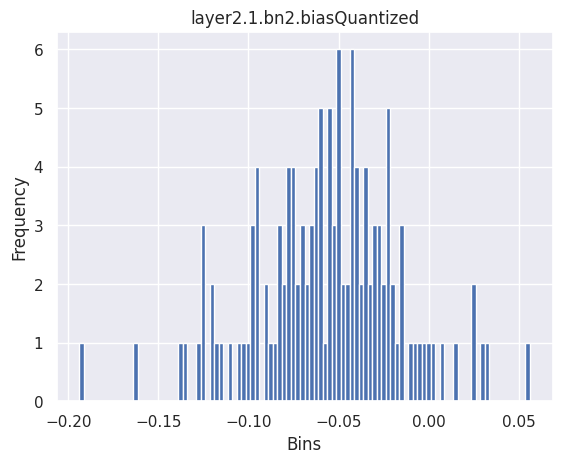

layer3.0.conv1.weight


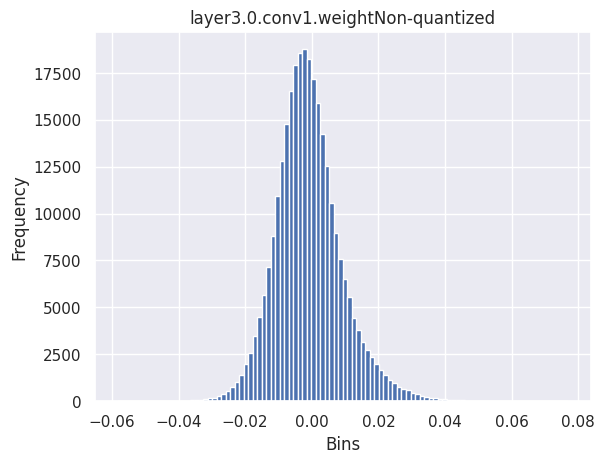

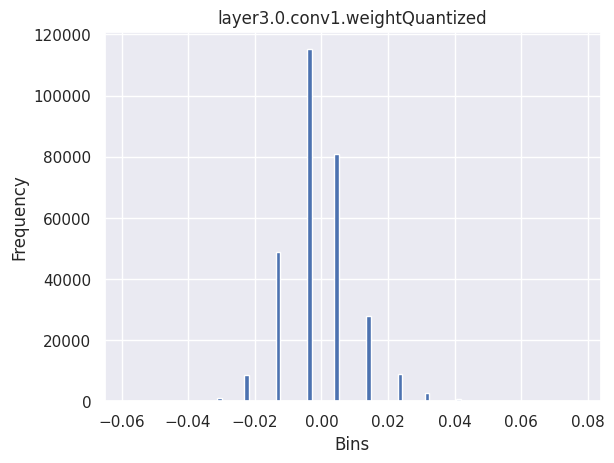

torch.Size([100])
torch.Size([101])
layer3.0.bn1.weight


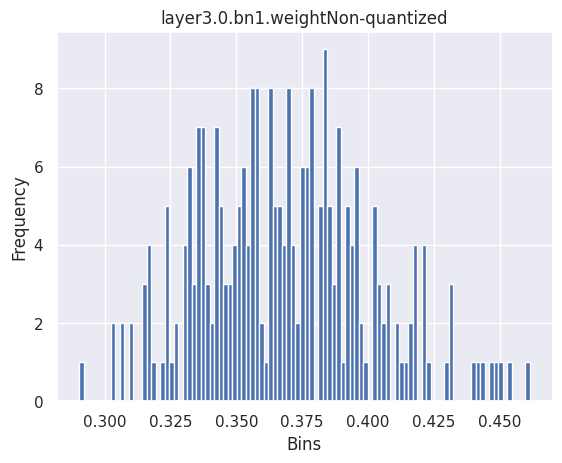

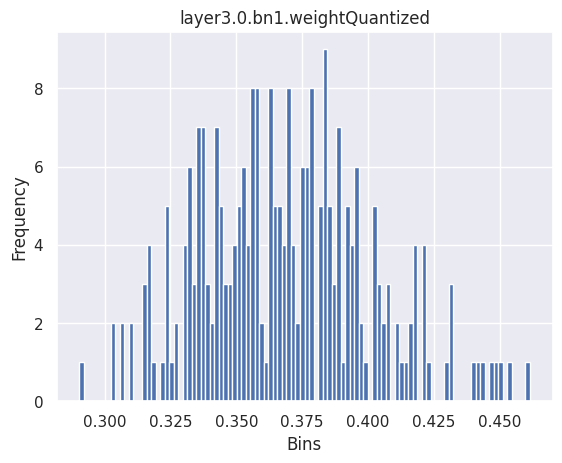

layer3.0.bn1.bias


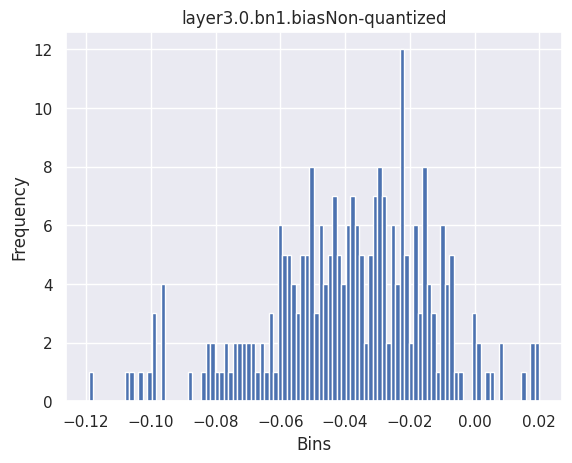

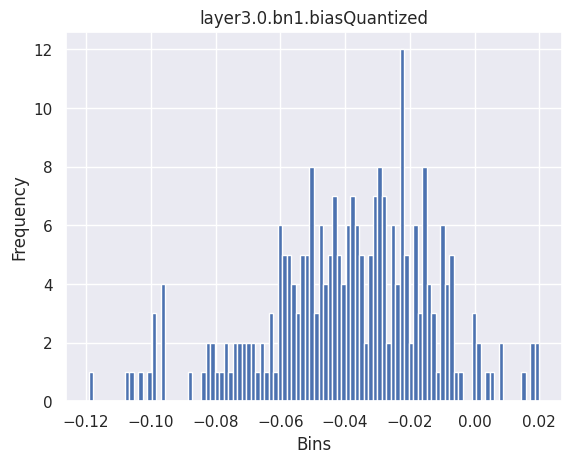

layer3.0.conv2.weight


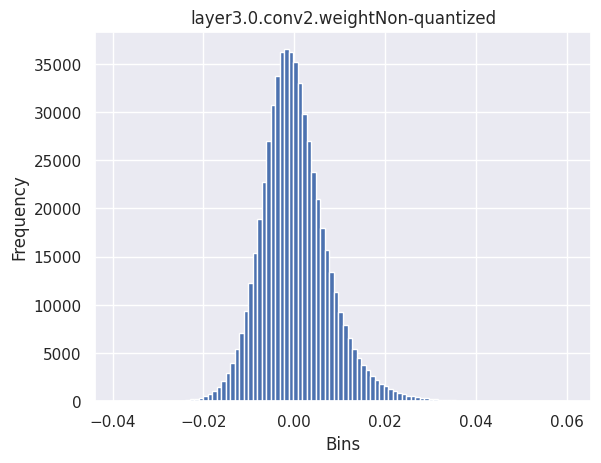

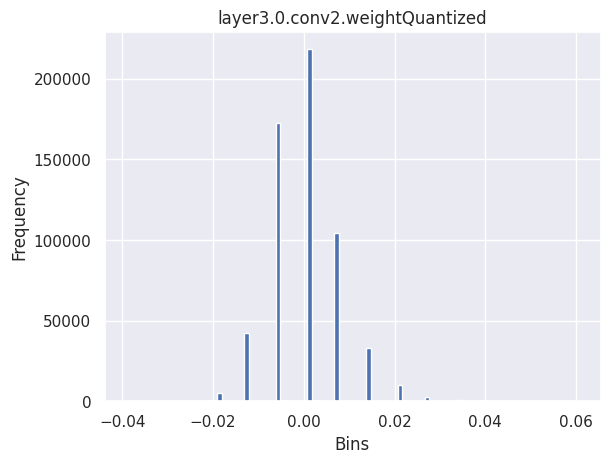

torch.Size([100])
torch.Size([101])
layer3.0.bn2.weight


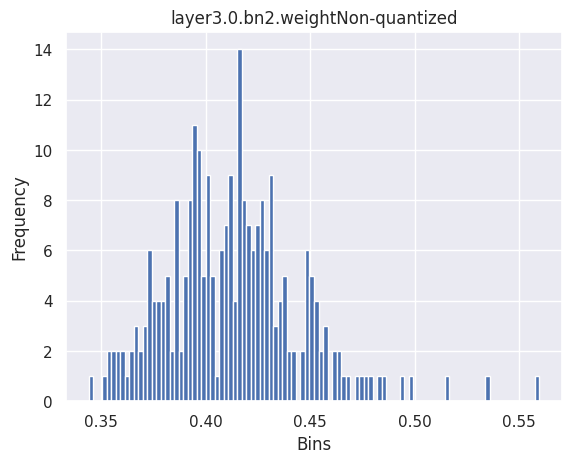

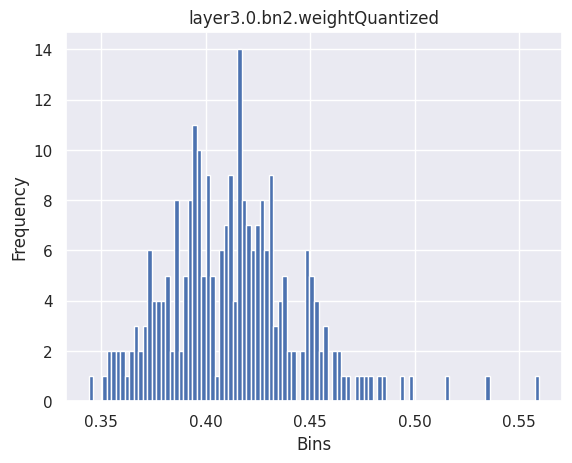

layer3.0.bn2.bias


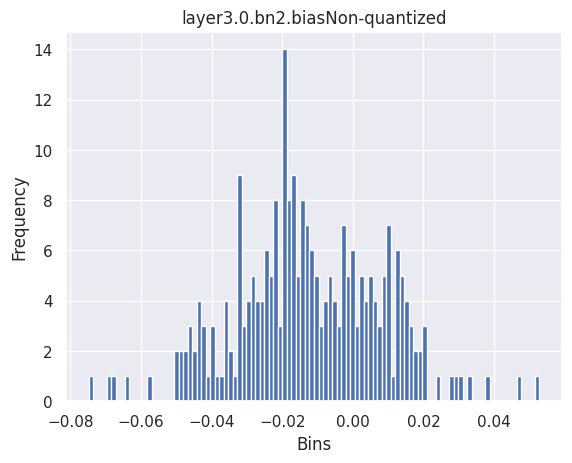

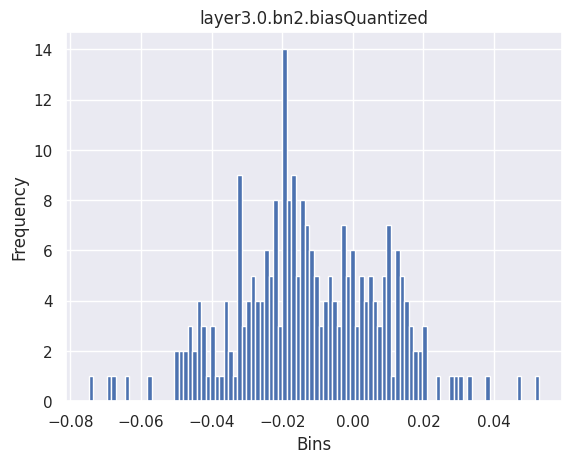

layer3.0.shortcut.0.weight


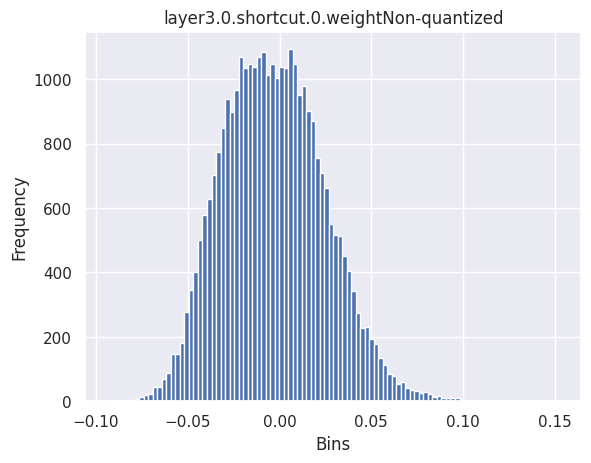

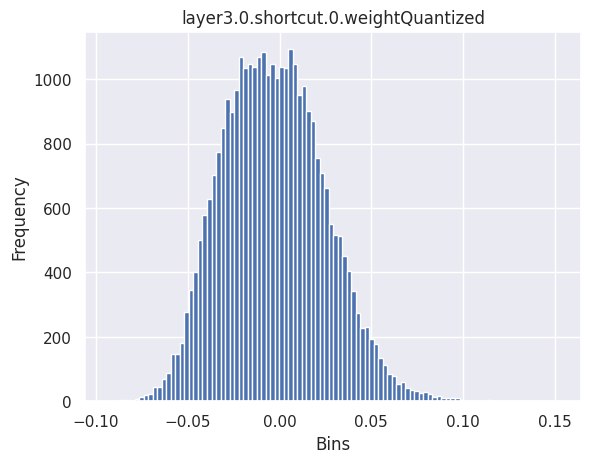

layer3.0.shortcut.1.weight


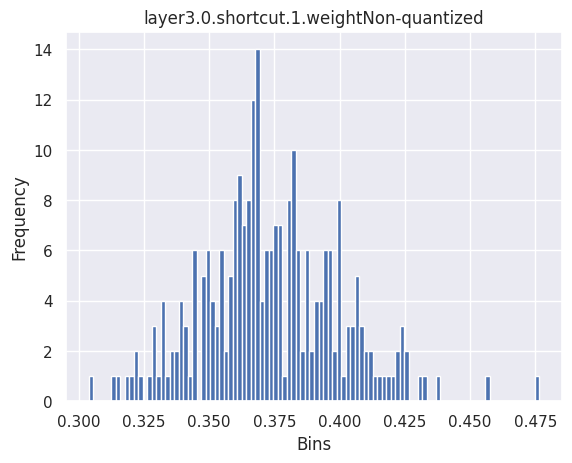

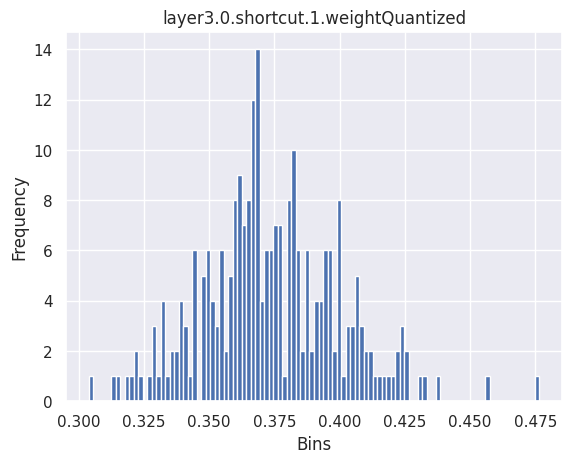

layer3.0.shortcut.1.bias


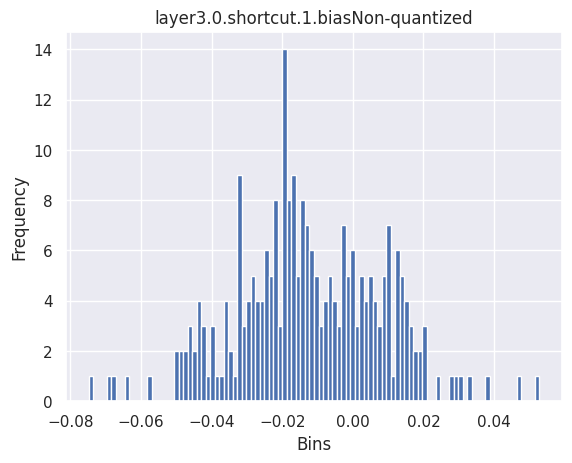

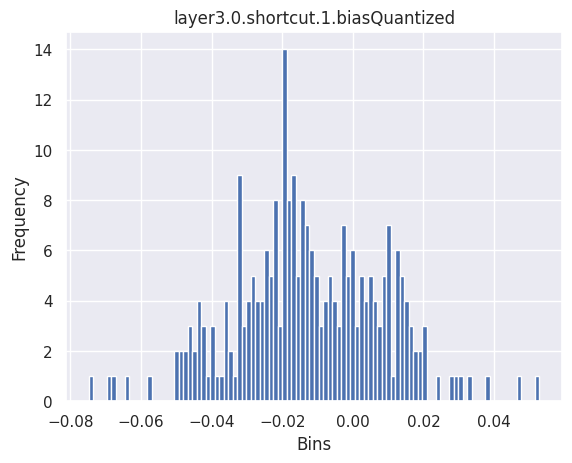

layer3.1.conv1.weight


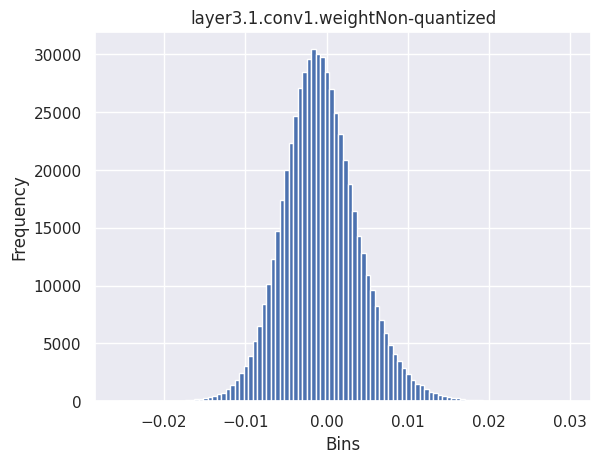

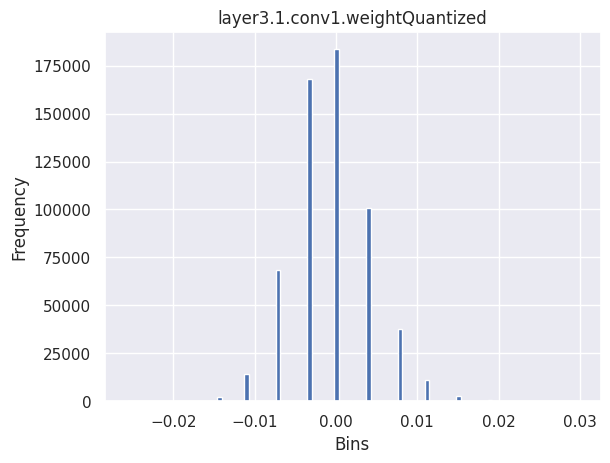

torch.Size([100])
torch.Size([101])
layer3.1.bn1.weight


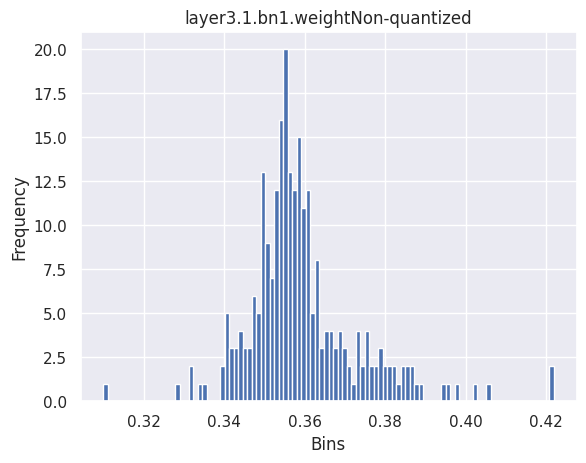

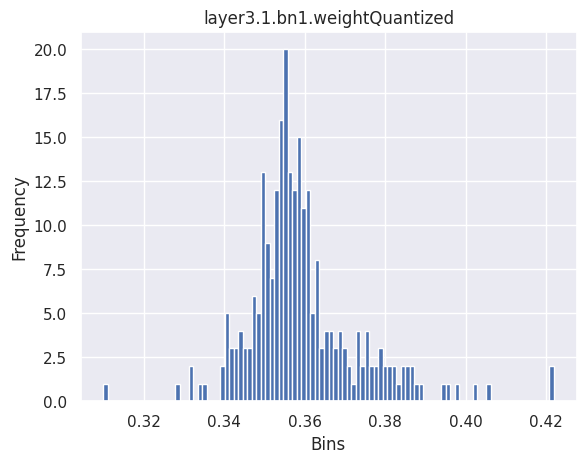

layer3.1.bn1.bias


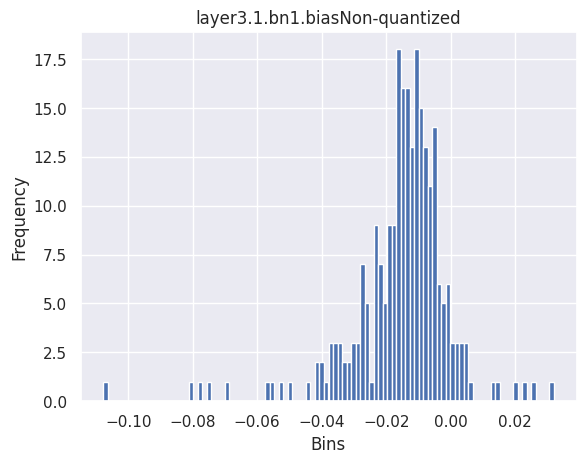

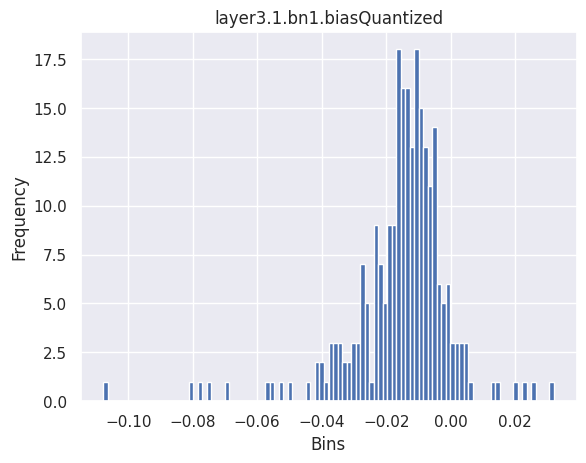

layer3.1.conv2.weight


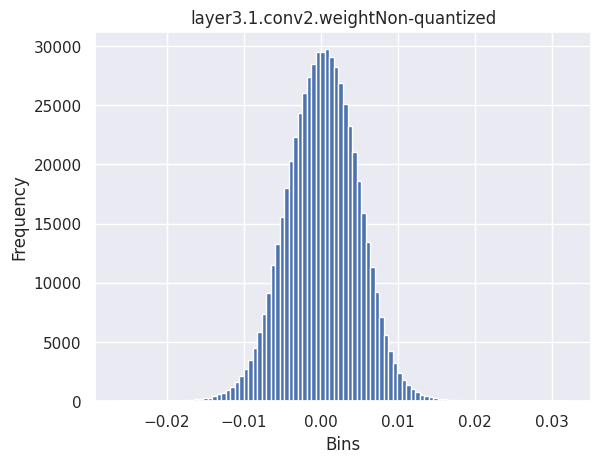

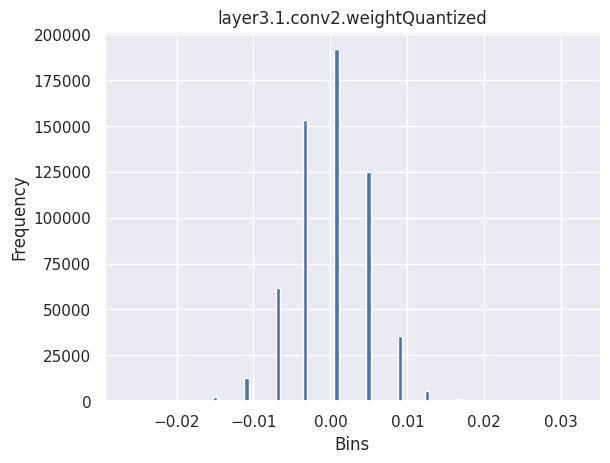

torch.Size([100])
torch.Size([101])
layer3.1.bn2.weight


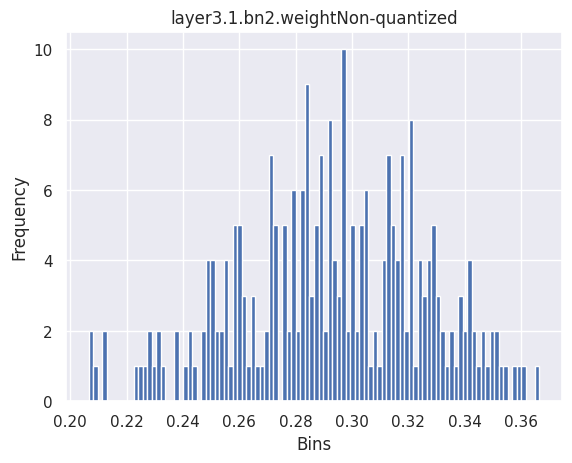

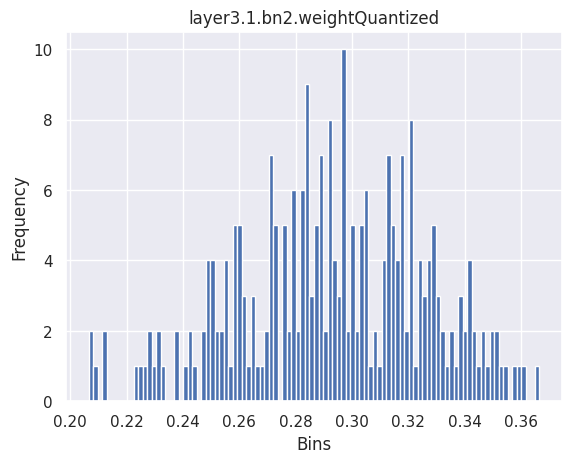

layer3.1.bn2.bias


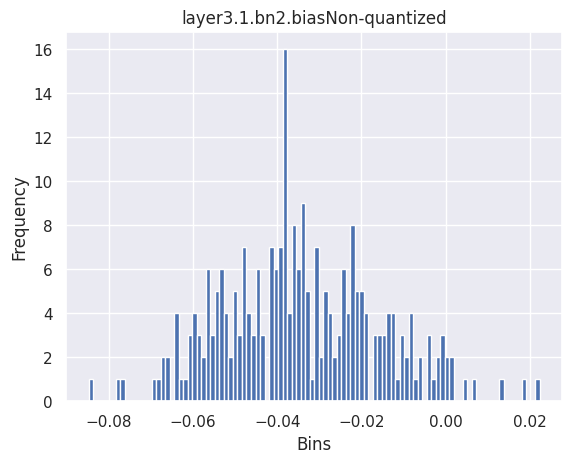

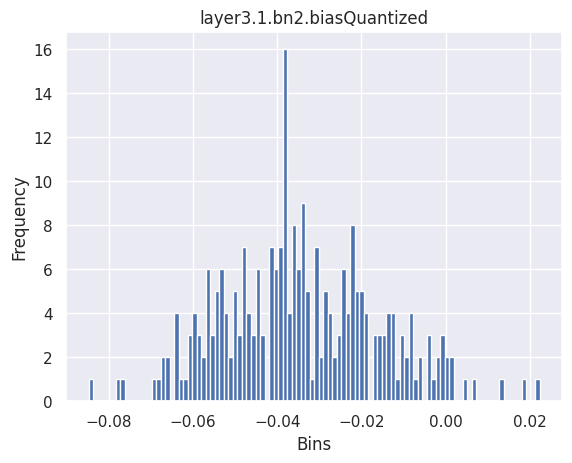

layer4.0.conv1.weight


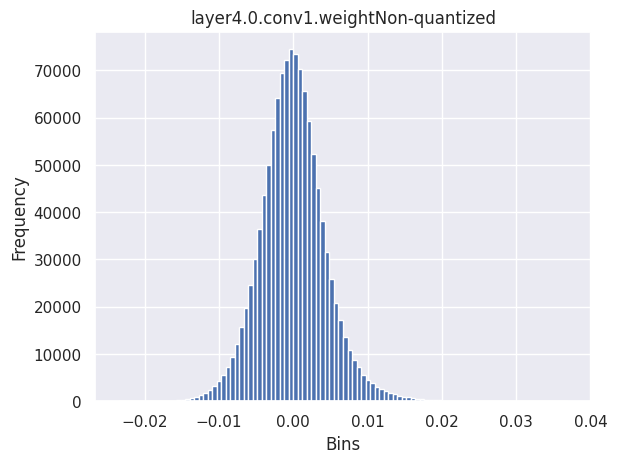

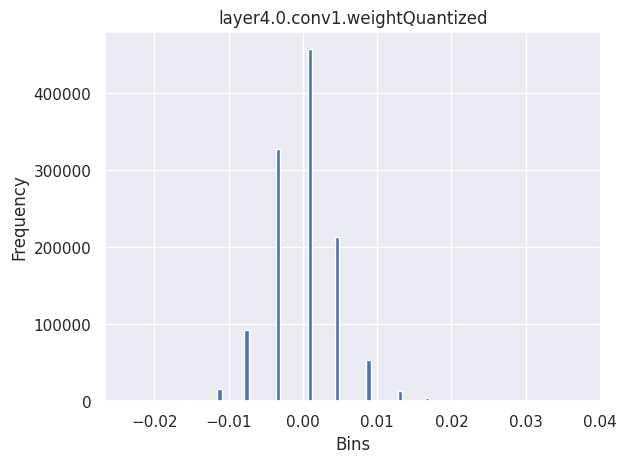

torch.Size([100])
torch.Size([101])
layer4.0.bn1.weight


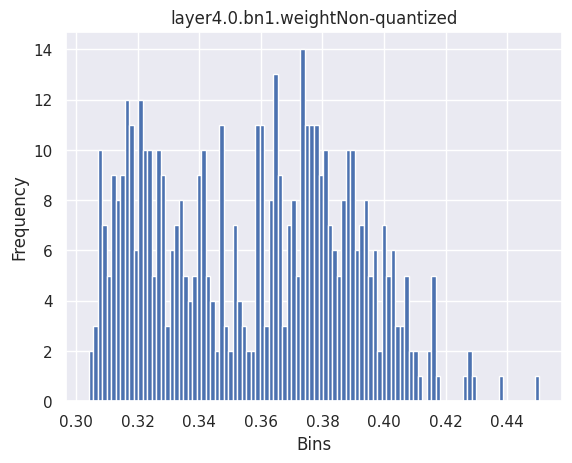

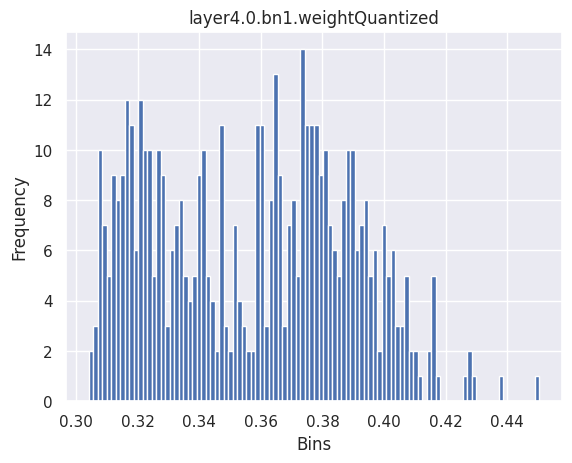

layer4.0.bn1.bias


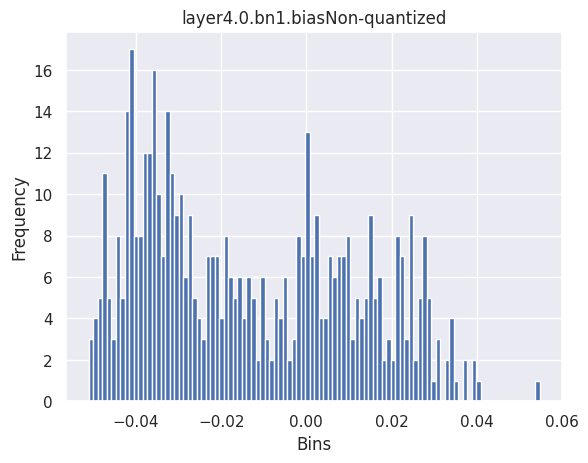

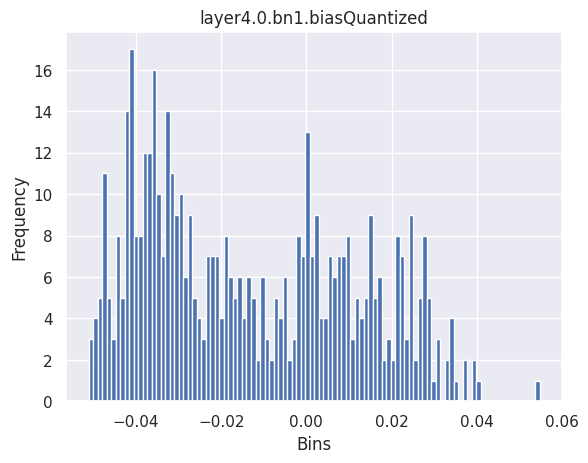

layer4.0.conv2.weight


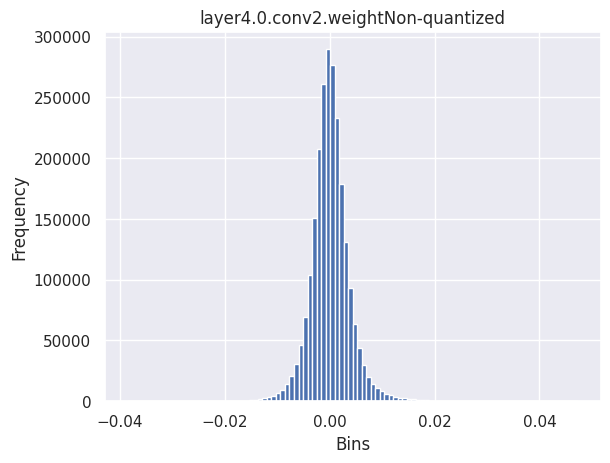

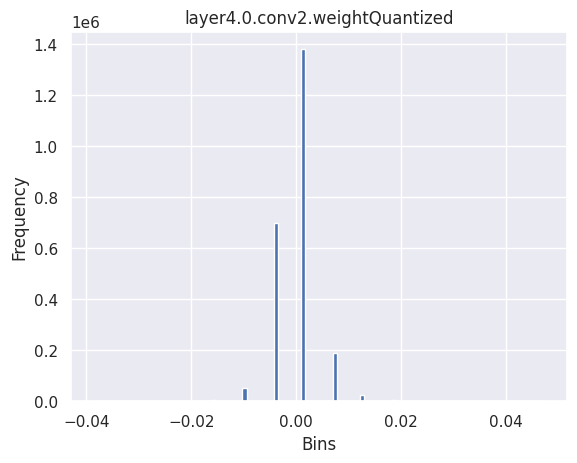

torch.Size([100])
torch.Size([101])
layer4.0.bn2.weight


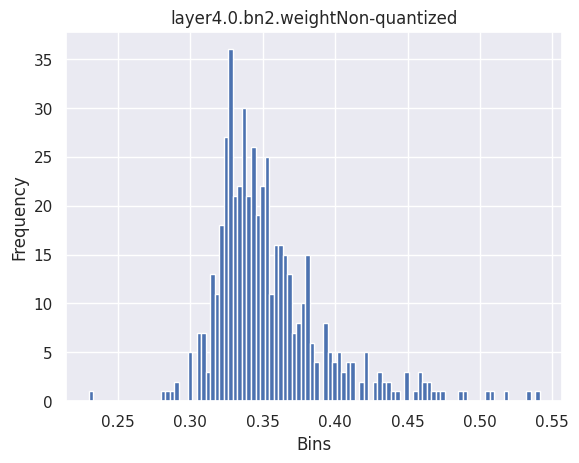

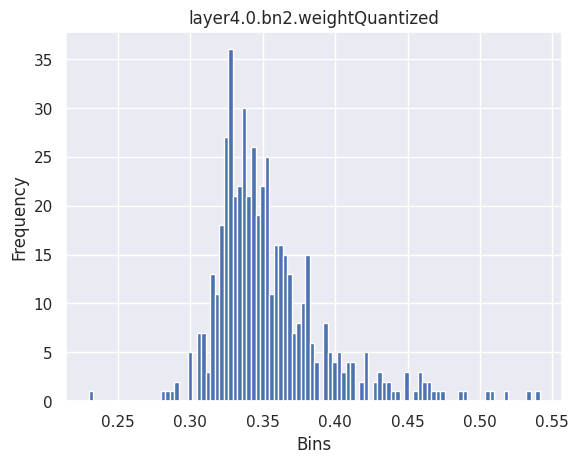

layer4.0.bn2.bias


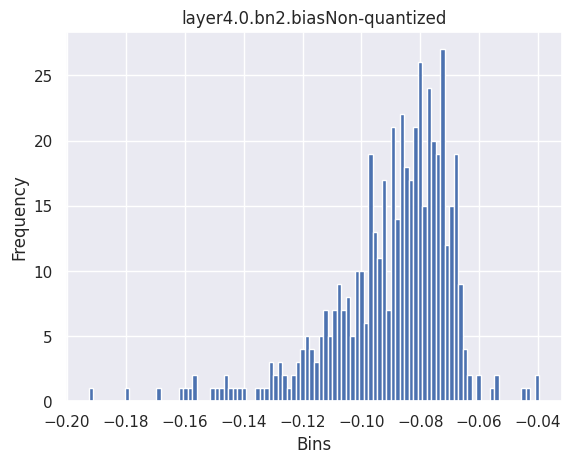

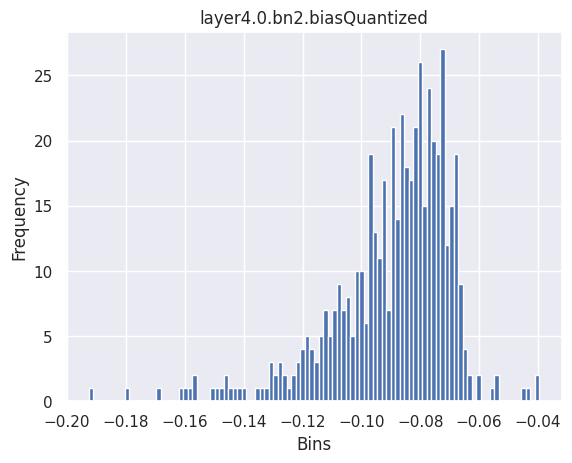

layer4.0.shortcut.0.weight


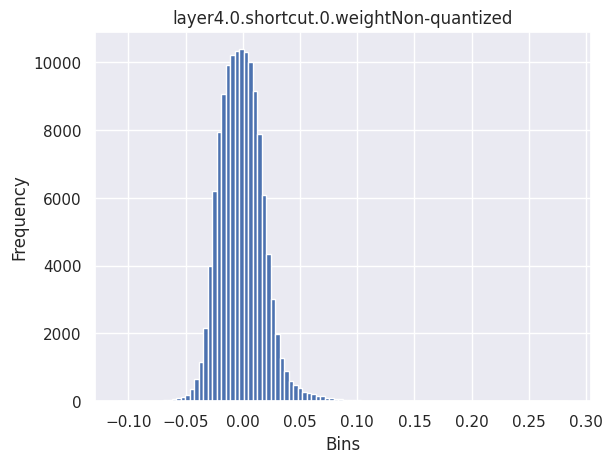

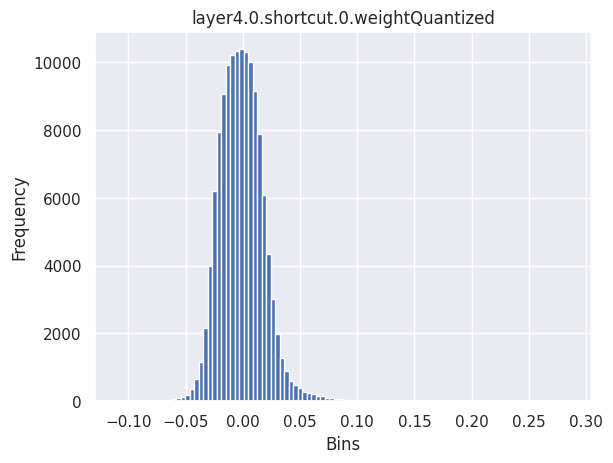

layer4.0.shortcut.1.weight


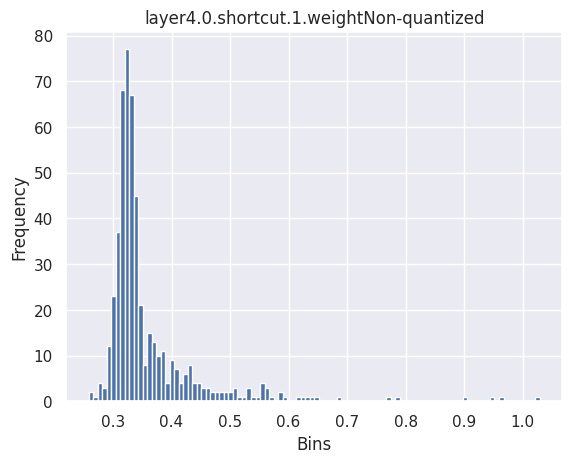

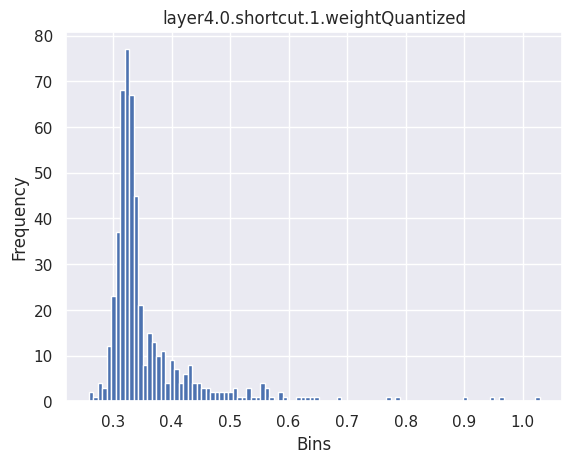

layer4.0.shortcut.1.bias


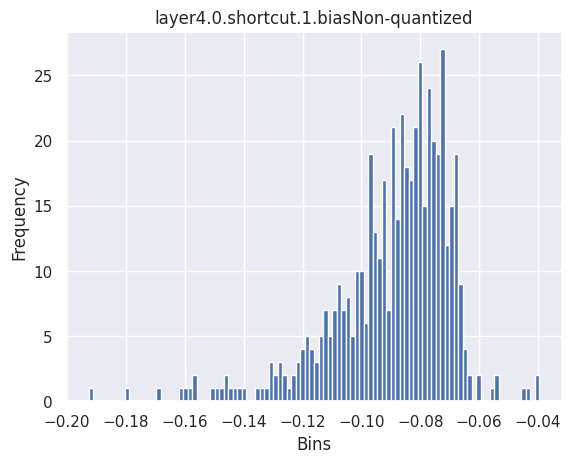

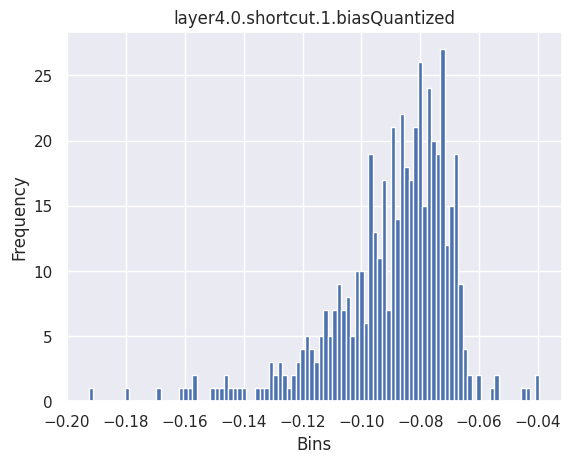

layer4.1.conv1.weight


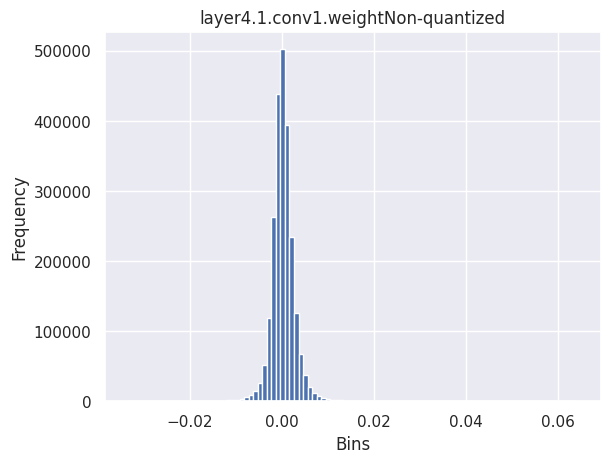

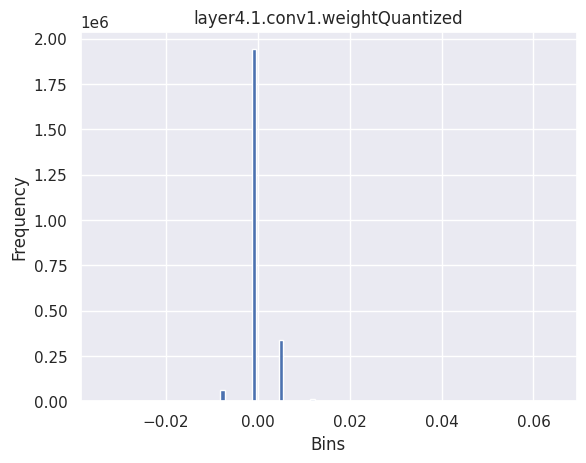

torch.Size([100])
torch.Size([101])
layer4.1.bn1.weight


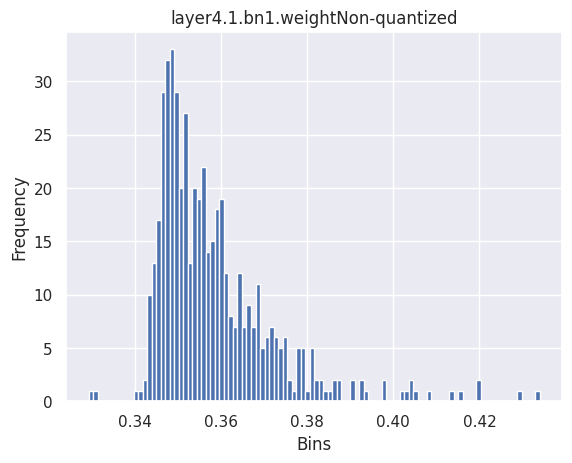

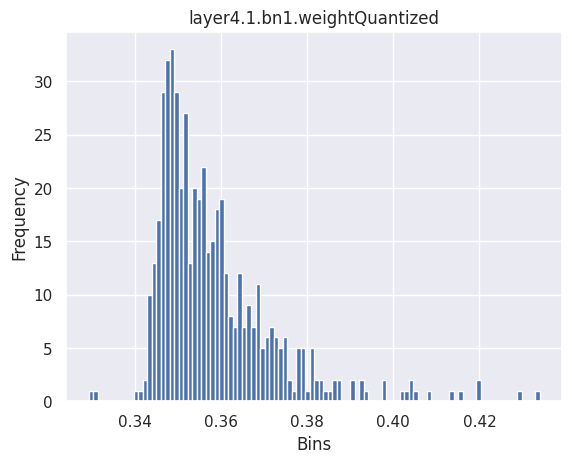

layer4.1.bn1.bias


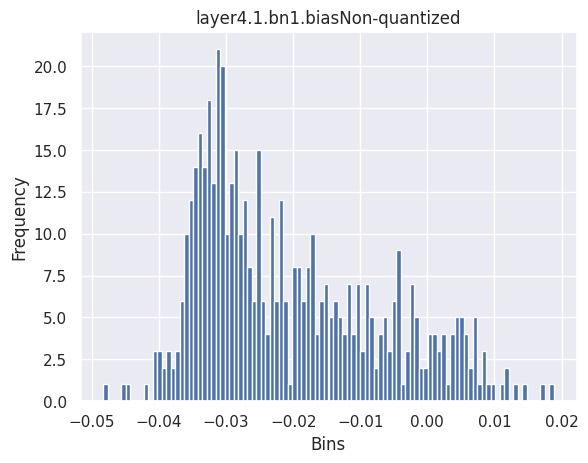

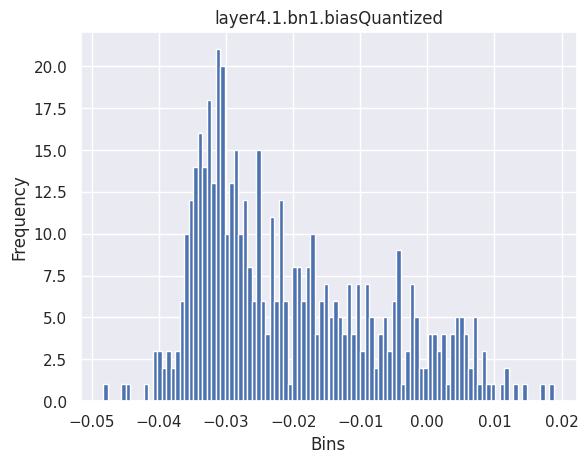

layer4.1.conv2.weight


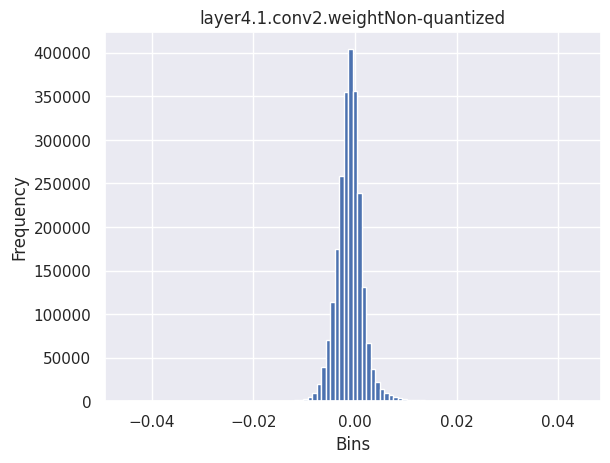

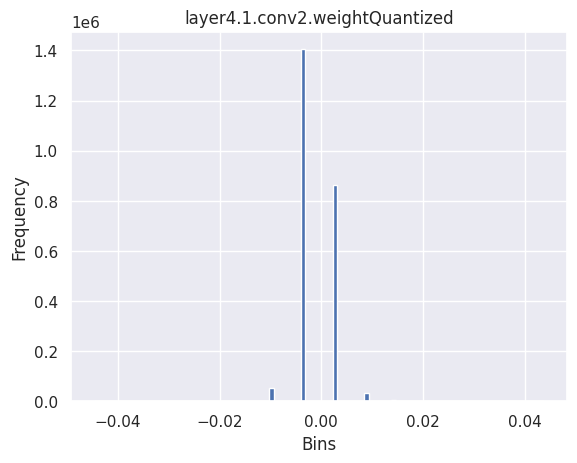

torch.Size([100])
torch.Size([101])
layer4.1.bn2.weight


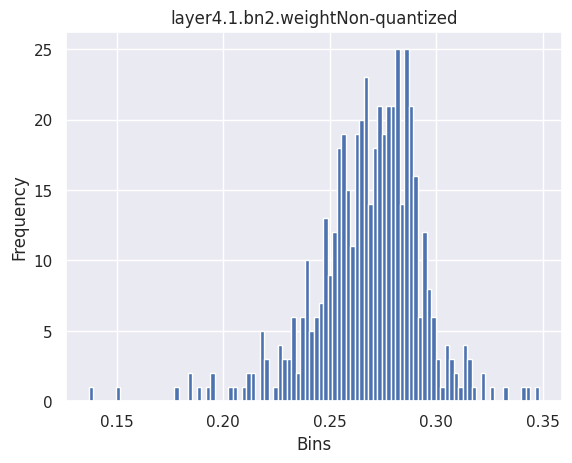

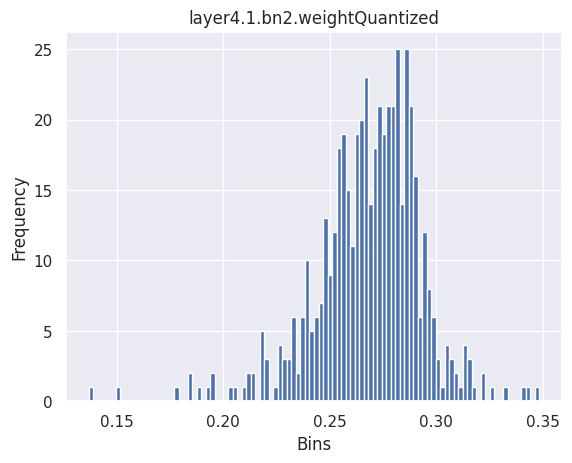

layer4.1.bn2.bias


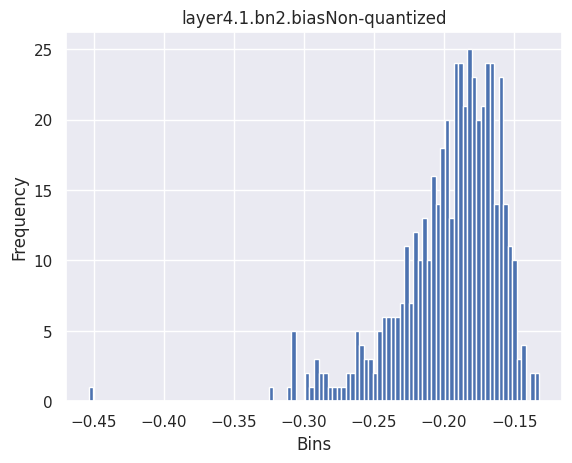

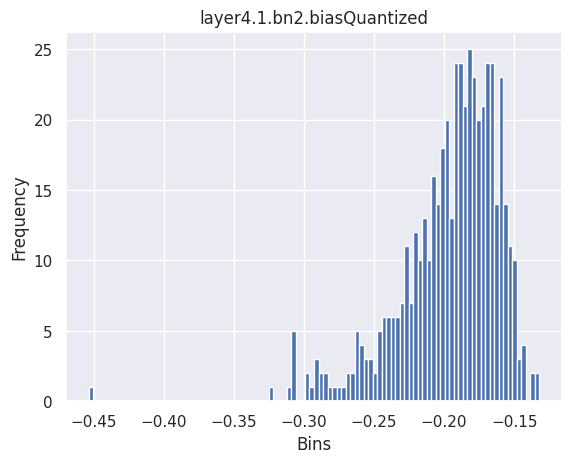

linear.weight


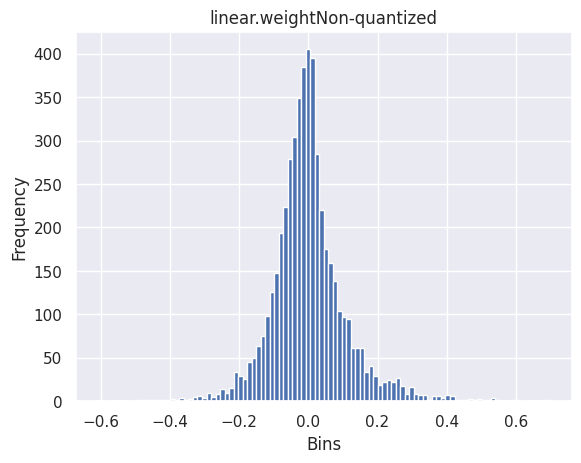

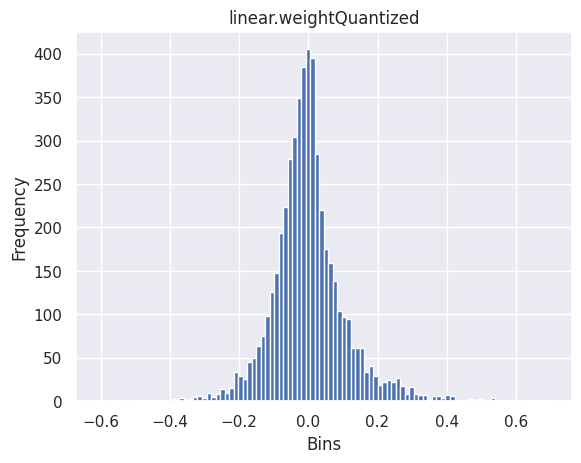

linear.bias


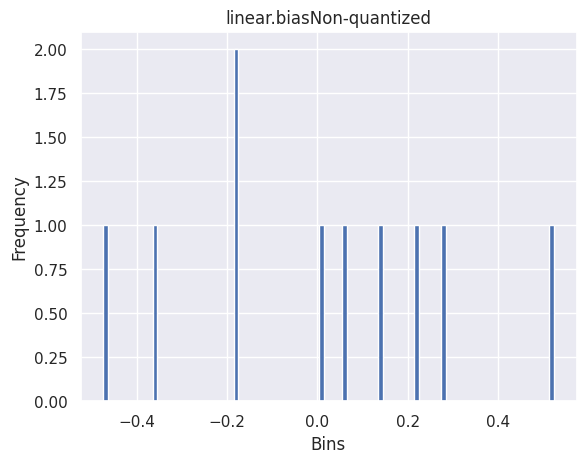

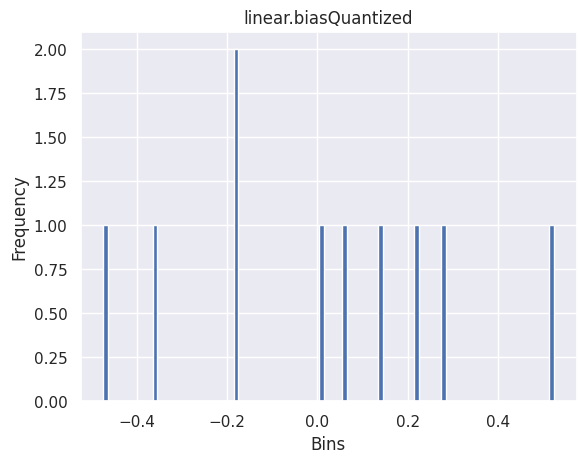

In [21]:
for key in dicta:
    if 'weight' in key or 'bias' in key:
        print(key)
        hist = torch.histogram(dicta[key].to(torch.device('cpu')))
        plot_histogram(hist[0], hist[1], title=key+'Non-quantized')
        hist = torch.histogram(dictd[key].to(torch.device('cpu')))
        plot_histogram(hist[0], hist[1], title=key+'Quantized')
        if 'conv' in key:
            print(hist[0].shape)
            print(hist[1].shape)

 